# 객체 검출 (Object Detection)

이 노트북에서는 LiDAR 포인트 클라우드 및 카메라 이미지를 활용한 객체 검출 방법에 대해 학습하고, 다양한 객체 검출 알고리즘을 구현합니다.

## 학습 목표

- 객체 검출의 기본 개념 및 접근 방식 이해
- 포인트 클라우드 기반 클러스터링 구현
- 2D/3D 바운딩 박스 생성 및 처리 방법 학습
- 객체 분류를 위한 기하학적 특징 추출
- 딥러닝 기반 객체 검출 방법 이해
- 센서 융합 기반 객체 검출 구현
- 객체 검출 성능 평가 방법 학습

## 1. 필요한 라이브러리 설치 및 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
from glob import glob
import open3d as o3d
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.calibration import (
    load_calib_data,
    lidar_to_camera,
    camera_to_image,
    lidar_to_image,
    get_fov_mask
)

from utils.ground_detection import (
    ransac_ground_detection,
    extract_ground_points,
    remove_ground_points
)

from utils.object_detection import (
    euclidean_clustering,
    compute_bounding_boxes,
    compute_features,
    classify_objects,
    detect_objects
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# 한글 폰트 설정 (필요한 경우)
try:
    import platform
    if platform.system() == 'Windows':
        # Windows
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin':
        # macOS
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        # Linux
        plt.rcParams['font.family'] = 'NanumGothic'
    
    # minus 기호 표시 문제 해결
    matplotlib.rcParams['axes.unicode_minus'] = False
    print("한글 폰트 설정 완료")
except:
    print("한글 폰트 설정 실패. 영문으로 표시합니다.")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
한글 폰트 설정 완료


## 2. 객체 검출의 기본 개념

객체 검출은 주어진 데이터(이미지, 포인트 클라우드 등)에서 객체를 찾고 분류하는 작업입니다. 자율주행에서는 차량, 보행자, 자전거, 표지판 등 다양한 객체를 검출하고 추적해야 합니다.

### 객체 검출 접근 방식

1. **전통적인 방법**:
   - 특징 추출 및 분류기 사용 (HOG, SVM 등)
   - 클러스터링 및 기하학적 분석
   - 템플릿 매칭

2. **딥러닝 기반 방법**:
   - 2D 객체 검출: Faster R-CNN, YOLO, SSD
   - 3D 객체 검출: PointRCNN, VoxelNet, SECOND
   - 멀티모달 융합: MV3D, AVOD, MMF

3. **센서 융합 기반 방법**:
   - LiDAR와 카메라 데이터 융합
   - 멀티모달 특징 추출 및 합성
   - 센서별 결과 통합

## 3. 데이터 로드

KITTI 데이터셋에서 LiDAR 포인트 클라우드, 카메라 이미지, 캘리브레이션 파일을 로드합니다.

포인트 클라우드 로드 완료: (124202, 4)
이미지 로드 완료: (370, 1224, 3)
캘리브레이션 데이터 로드 완료: ['P0', 'P1', 'P2', 'P3', 'R0_rect', 'Tr_velo_to_cam', 'Tr_imu_to_velo', 'velo_to_cam_rect']
포인트 개수: 124202
X 범위: [-64.73, 64.55]
Y 범위: [-75.70, 75.32]
Z 범위: [-4.46, 2.91]
강도 범위: [0.00, 0.99]


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

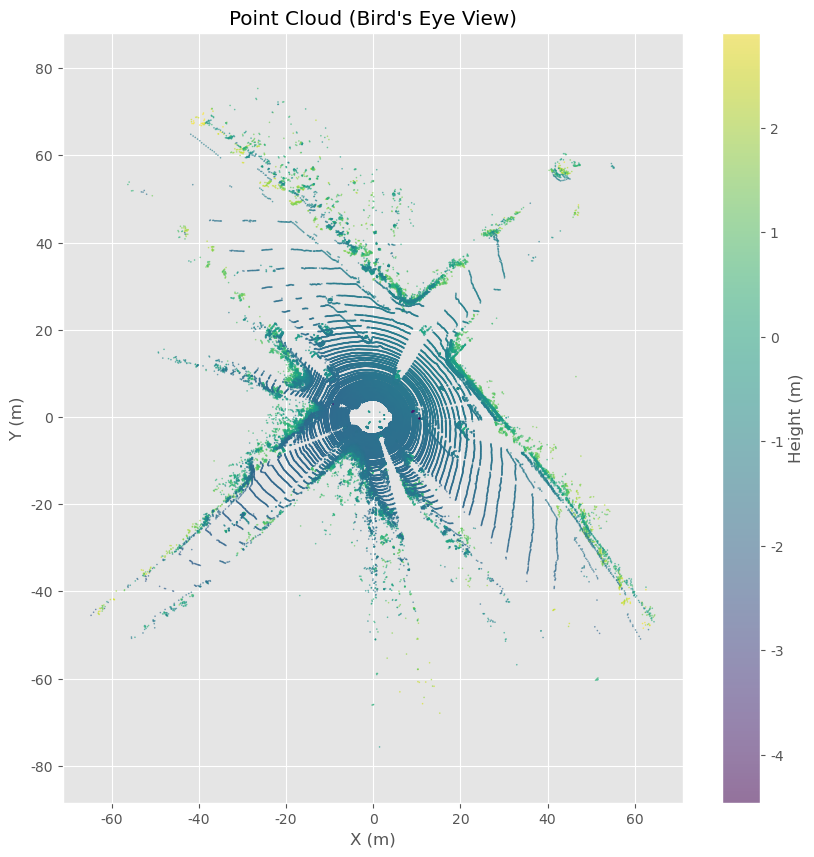

In [2]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

def load_calib_data_safe(calib_filepath):
    """
    안전하게 캘리브레이션 데이터 로드
    
    Args:
        calib_filepath (str): 캘리브레이션 파일 경로
        
    Returns:
        dict: 캘리브레이션 데이터
    """
    try:
        return load_calib_data(calib_filepath)
    except Exception as e:
        print(f"캘리브레이션 파일 로드 중 오류: {e}")
        print("기본 캘리브레이션 데이터를 사용합니다.")
        
        # 예시 캘리브레이션 데이터
        return {
            'P2': np.array([
                [721.5377, 0.0, 609.5593, 44.85728],
                [0.0, 721.5377, 172.854, 0.2163791],
                [0.0, 0.0, 1.0, 0.002745884]
            ]),
            'R0_rect': np.eye(3),
            'Tr_velo_to_cam': np.array([
                [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
                [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
                [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
                [0.0, 0.0, 0.0, 1.0]
            ])
        }

# 데이터 경로 설정
# data_dir = '/home/shbyun/KITTI/ObjectDetection/'
# point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
# image_dir = os.path.join(data_dir, 'data_object_image_2/training', 'image_2')
# calib_dir = os.path.join(data_dir, 'data_object_calib/training', 'calib')
data_dir = '/home/shbyun/Coding/OpenPCDet/data/kitti/training/'
point_cloud_dir = os.path.join(data_dir, 'velodyne')
image_dir = os.path.join(data_dir, 'image_2')
calib_dir = os.path.join(data_dir, 'calib')

# 첫 번째 프레임 로드
# frame_id = '000000'
frame_id = '000206'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
image_path = os.path.join(image_dir, f'{frame_id}.png')
calib_path = os.path.join(calib_dir, f'{frame_id}.txt')

# 데이터 로드
if os.path.exists(point_cloud_path) and os.path.exists(image_path):
    points = load_point_cloud(point_cloud_path)
    image = load_image(image_path)
    
    if os.path.exists(calib_path):
        calib_data = load_calib_data_safe(calib_path)
    else:
        print(f"캘리브레이션 파일을 찾을 수 없습니다: {calib_path}")
        # 예시 캘리브레이션 데이터 사용
        calib_data = {
            'P2': np.array([
                [721.5377, 0.0, 609.5593, 44.85728],
                [0.0, 721.5377, 172.854, 0.2163791],
                [0.0, 0.0, 1.0, 0.002745884]
            ]),
            'R0_rect': np.eye(3),
            'Tr_velo_to_cam': np.array([
                [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
                [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
                [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
                [0.0, 0.0, 0.0, 1.0]
            ])
        }
    
    print(f"포인트 클라우드 로드 완료: {points.shape}")
    print(f"이미지 로드 완료: {image.shape}")
    print(f"캘리브레이션 데이터 로드 완료: {list(calib_data.keys())}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print("경로에 KITTI 데이터가 없습니다. 예시 데이터를 생성합니다...")
    
    # 예시 포인트 클라우드 생성
    num_points = 20000
    x = np.random.uniform(-30, 30, num_points)
    y = np.random.uniform(-30, 30, num_points)
    z = np.random.uniform(-2, 5, num_points)
    intensity = np.random.uniform(0, 1, num_points)
    points = np.column_stack((x, y, z, intensity))
    
    # 지면 점 생성
    ground_idx = np.random.choice(num_points, int(num_points*0.6), replace=False)
    points[ground_idx, 2] = -1.7 + np.random.normal(0, 0.1, len(ground_idx))
    
    # 객체 생성 (자동차, 보행자, 기타)
    # 자동차 1
    car1_center = np.array([10, 0, -0.5])
    car1_points = generate_car_points(car1_center, 100)
    # 자동차 2
    car2_center = np.array([-5, 8, -0.5])
    car2_points = generate_car_points(car2_center, 100)
    # 보행자
    ped_center = np.array([8, -5, -0.5])
    ped_points = generate_pedestrian_points(ped_center, 50)
    
    # 포인트 클라우드에 객체 추가
    points = np.vstack([points, car1_points, car2_points, ped_points])
    
    # 예시 이미지 생성 (검은 배경에 그리드)
    image = np.zeros((375, 1242, 3), dtype=np.uint8)
    for i in range(0, image.shape[0], 50):
        cv2.line(image, (0, i), (image.shape[1], i), (50, 50, 50), 1)
    for i in range(0, image.shape[1], 50):
        cv2.line(image, (i, 0), (i, image.shape[0]), (50, 50, 50), 1)
    
    # 예시 캘리브레이션 데이터
    calib_data = {
        'P2': np.array([
            [721.5377, 0.0, 609.5593, 44.85728],
            [0.0, 721.5377, 172.854, 0.2163791],
            [0.0, 0.0, 1.0, 0.002745884]
        ]),
        'R0_rect': np.eye(3),
        'Tr_velo_to_cam': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
            [0.0, 0.0, 0.0, 1.0]
        ])
    }
    
    print(f"예시 포인트 클라우드 생성 완료: {points.shape}")
    print(f"예시 이미지 생성 완료: {image.shape}")
    print(f"예시 캘리브레이션 데이터 생성 완료")

# 포인트 클라우드 통계
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")

# 예시 객체 생성 함수
def generate_car_points(center, num_points):
    """
    자동차 형태의 포인트 클라우드 생성
    
    Args:
        center (numpy.ndarray): 자동차 중심 위치 [x, y, z]
        num_points (int): 생성할 포인트 수
        
    Returns:
        numpy.ndarray: 자동차 포인트 클라우드 [N, 4]
    """
    # 자동차 크기 설정
    length, width, height = 4.5, 1.8, 1.5
    
    # 무작위 포인트 생성
    x = np.random.uniform(-length/2, length/2, num_points) + center[0]
    y = np.random.uniform(-width/2, width/2, num_points) + center[1]
    z = np.random.uniform(0, height, num_points) + center[2]
    
    # 강도 값 설정
    intensity = np.random.uniform(0.5, 0.8, num_points)
    
    return np.column_stack((x, y, z, intensity))

def generate_pedestrian_points(center, num_points):
    """
    보행자 형태의 포인트 클라우드 생성
    
    Args:
        center (numpy.ndarray): 보행자 중심 위치 [x, y, z]
        num_points (int): 생성할 포인트 수
        
    Returns:
        numpy.ndarray: 보행자 포인트 클라우드 [N, 4]
    """
    # 보행자 크기 설정
    width, depth, height = 0.6, 0.6, 1.8
    
    # 무작위 포인트 생성
    x = np.random.uniform(-width/2, width/2, num_points) + center[0]
    y = np.random.uniform(-depth/2, depth/2, num_points) + center[1]
    z = np.random.uniform(0, height, num_points) + center[2]
    
    # 강도 값 설정
    intensity = np.random.uniform(0.3, 0.6, num_points)
    
    return np.column_stack((x, y, z, intensity))

# 데이터 시각화
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.title('Camera Image')
plt.axis('off')
plt.show()

# 포인트 클라우드 시각화 (BEV)
plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=0.5, alpha=0.5)
plt.colorbar(label='Height (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Point Cloud (Bird\'s Eye View)')
plt.axis('equal')
plt.grid(True)
plt.show()


## 4. 지면 검출 및 제거

객체 검출의 전처리 단계로 지면 포인트를 검출하고 제거합니다.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

전체 포인트 개수: 124202
지면 포인트 개수: 88244
지면 포인트 비율: 71.05%
지면 방정식: 0.0039x + 0.0148y + -0.9999z + -1.6684 = 0
비지면 포인트 개수: 35958


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

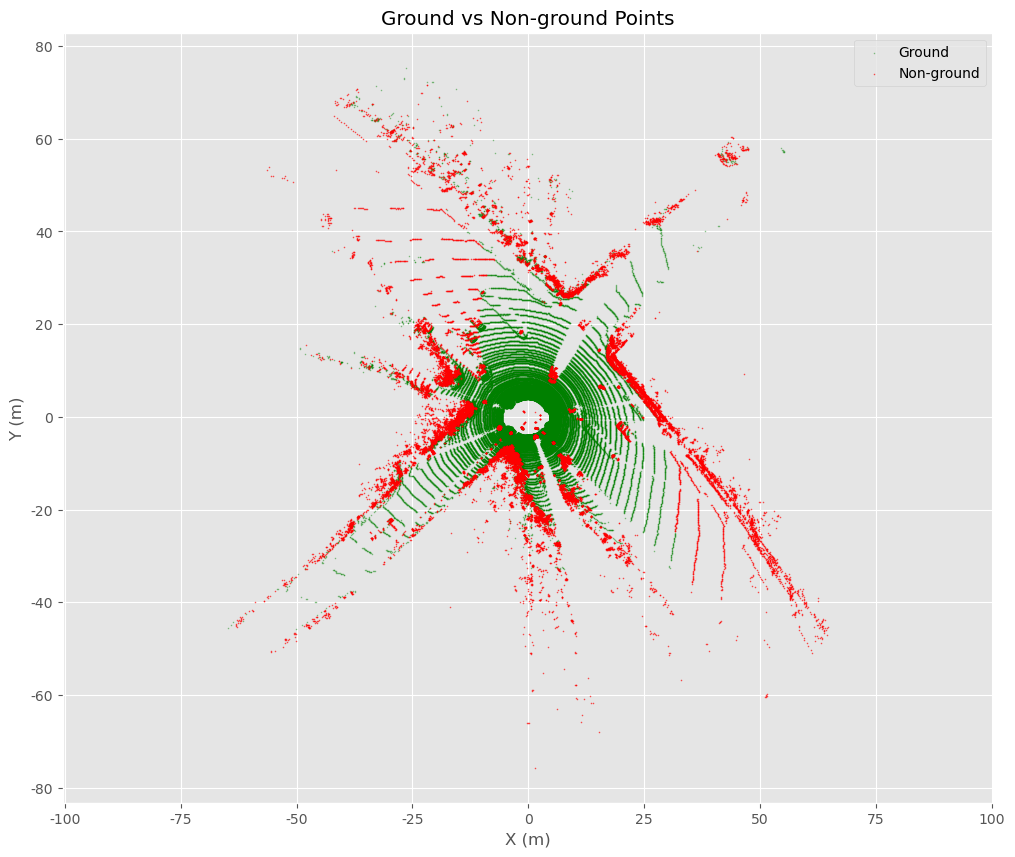

In [3]:
# RANSAC 기반 지면 검출
distance_thresh = 0.5  # 인라이어로 간주하는 평면과의 최대 거리 (m)
max_iterations = 100   # RANSAC 최대 반복 횟수

# 지면 검출
ground_mask, ground_model = ransac_ground_detection(
    points, distance_thresh=distance_thresh, 
    max_iterations=max_iterations, return_model=True
)

# 결과 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"지면 포인트 개수: {np.sum(ground_mask)}")
print(f"지면 포인트 비율: {np.sum(ground_mask) / points.shape[0] * 100:.2f}%")
print(f"지면 방정식: {ground_model['normal'][0]:.4f}x + {ground_model['normal'][1]:.4f}y + {ground_model['normal'][2]:.4f}z + {ground_model['intercept']:.4f} = 0")

# 지면 제거
non_ground_points = remove_ground_points(points, ground_mask)
print(f"비지면 포인트 개수: {non_ground_points.shape[0]}")

# 시각화 (지면/비지면 구분)
plt.figure(figsize=(12, 10))

# 지면 포인트
ground_points = extract_ground_points(points, ground_mask)
plt.scatter(ground_points[:, 0], ground_points[:, 1], c='green', s=0.5, alpha=0.3, label='Ground')

# 비지면 포인트
plt.scatter(non_ground_points[:, 0], non_ground_points[:, 1], c='red', s=0.5, alpha=0.5, label='Non-ground')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ground vs Non-ground Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

## 5. 포인트 클라우드 클러스터링

비지면 포인트를 클러스터링하여 객체 후보를 검출합니다.


검출된 클러스터 수: 197
유효한 클러스터 수: 196
클러스터 0: 4025 포인트
클러스터 1: 44 포인트
클러스터 2: 14 포인트
클러스터 3: 48 포인트
클러스터 4: 31 포인트
클러스터 5: 55 포인트
클러스터 6: 34 포인트
클러스터 7: 130 포인트
클러스터 8: 146 포인트
클러스터 9: 1102 포인트
클러스터 10: 30 포인트
클러스터 11: 174 포인트
클러스터 12: 14 포인트
클러스터 13: 26 포인트
클러스터 14: 83 포인트
클러스터 15: 166 포인트
클러스터 16: 65 포인트
클러스터 17: 39 포인트
클러스터 18: 23 포인트
클러스터 19: 17 포인트
클러스터 20: 26 포인트
클러스터 21: 24 포인트
클러스터 22: 21 포인트
클러스터 23: 15 포인트
클러스터 24: 35 포인트
클러스터 25: 46 포인트
클러스터 26: 22 포인트
클러스터 27: 20 포인트
클러스터 28: 180 포인트
클러스터 29: 10 포인트
클러스터 30: 22 포인트
클러스터 31: 36 포인트
클러스터 32: 14 포인트
클러스터 33: 229 포인트
클러스터 34: 1471 포인트
클러스터 35: 28 포인트
클러스터 36: 155 포인트
클러스터 37: 50 포인트
클러스터 38: 311 포인트
클러스터 39: 3558 포인트
클러스터 40: 11 포인트
클러스터 41: 72 포인트
클러스터 42: 35 포인트
클러스터 43: 28 포인트
클러스터 44: 226 포인트
클러스터 45: 294 포인트
클러스터 46: 70 포인트
클러스터 47: 149 포인트
클러스터 48: 17 포인트
클러스터 49: 363 포인트
클러스터 50: 32 포인트
클러스터 51: 187 포인트
클러스터 52: 29 포인트
클러스터 53: 59 포인트
클러스터 54: 12 포인트
클러스터 55: 29 포인트
클러스터 56: 879 포인트
클러스터 57: 58 포인트
클러스터 58: 10 포인트
클러스터 59: 15 

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

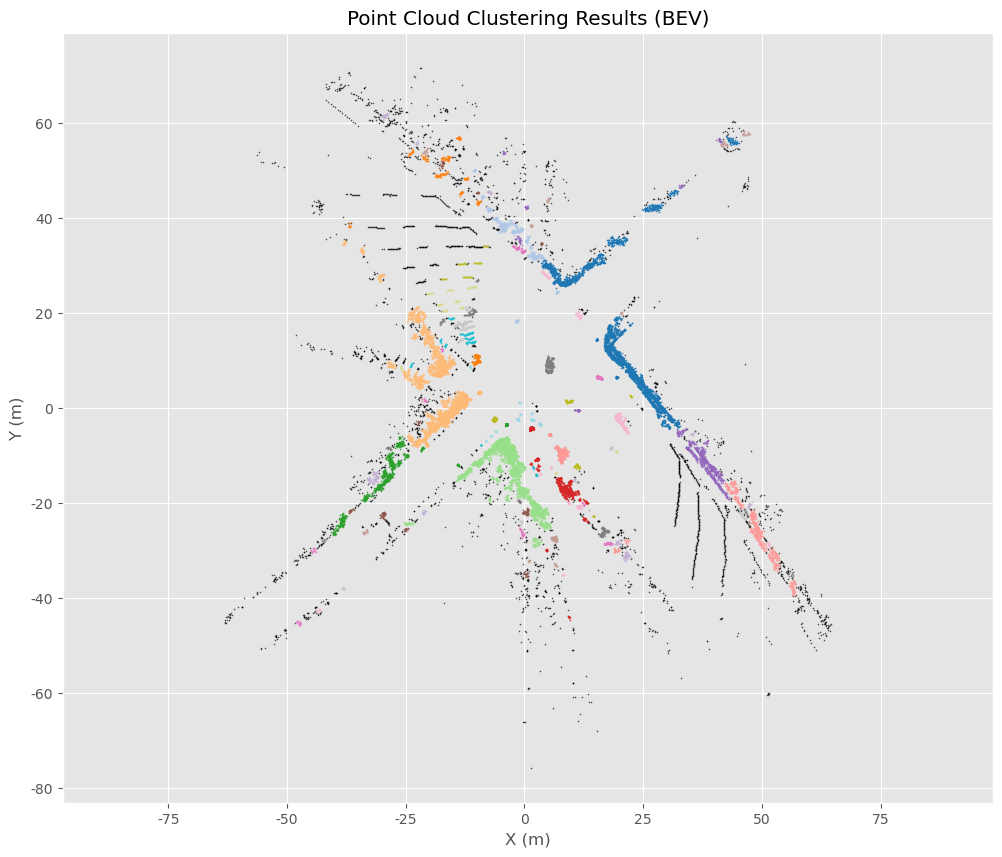

In [4]:
# DBSCAN 클러스터링
def dbscan_clustering(points, eps=0.5, min_samples=10, max_points=10000):
    """
    DBSCAN 알고리즘을 사용한 클러스터링
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        eps (float): 이웃 포인트 판단 거리 임계값
        min_samples (int): 핵심 포인트 판단을 위한 최소 이웃 수
        max_points (int): 클러스터 최대 포인트 수
        
    Returns:
        tuple: (클러스터 리스트, 레이블)
    """
    # DBSCAN 클러스터링 적용 (xy 평면에서만)
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(points[:, :2])
    labels = db.labels_
    
    # 클러스터 개수 (-1은 노이즈)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"검출된 클러스터 수: {n_clusters}")
    
    # 각 클러스터 추출
    clusters = []
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        
        # 너무 큰 클러스터는 필터링 (지면 잔여물일 가능성)
        if len(cluster_points) <= max_points:
            clusters.append(cluster_points)
    
    return clusters, labels

# Matplotlib을 사용한 클러스터링 시각화
def visualize_clusters_matplotlib(points, labels):
    """
    클러스터링 결과 시각화 (Matplotlib)
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        labels (numpy.ndarray): 클러스터 레이블 [N]
        
    Returns:
        None
    """
    # BEV 시각화
    plt.figure(figsize=(12, 10))
    
    # 노이즈 포인트 (레이블 -1)
    noise_points = points[labels == -1]
    plt.scatter(noise_points[:, 0], noise_points[:, 1], c='black', s=0.5, alpha=0.5, label='Noise')
    
    # 클러스터 포인트
    unique_labels = set(labels)
    unique_labels.discard(-1)  # 노이즈 레이블 제외
    
    # 색상 맵
    cmap = plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    
    # 각 클러스터 그리기
    for i, label in enumerate(unique_labels):
        cluster_points = points[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[i]], s=0.5, alpha=0.8, label=f'Cluster {label}')
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Point Cloud Clustering Results (BEV)')
    plt.axis('equal')
    plt.grid(True)
    
    # 범례는 너무 많은 클러스터가 있으면 생략
    if len(unique_labels) <= 20:
        plt.legend()
    
    plt.show()

# 비지면 포인트에 대해 클러스터링 수행
eps = 0.5  # 클러스터링 거리 임계값
min_samples = 10  # 최소 포인트 수
max_points = 5000  # 최대 클러스터 크기

clusters, labels = dbscan_clustering(non_ground_points, eps, min_samples, max_points)

print(f"유효한 클러스터 수: {len(clusters)}")
for i, cluster in enumerate(clusters):
    print(f"클러스터 {i}: {len(cluster)} 포인트")

# 클러스터링 결과 시각화
visualize_clusters_matplotlib(non_ground_points, labels)

In [9]:
import numpy as np
import open3d as o3d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def create_pca_bounding_box(points):
    """
    PCA를 사용하여 포인트 클라우드에 방향성 바운딩 박스를 생성합니다.
    
    Args:
        points: Numpy array of shape (N, 3) 포인트 좌표
        
    Returns:
        center: 바운딩 박스의 중심점
        dimensions: 바운딩 박스의 크기 (length, width, height)
        rotation_matrix: 바운딩 박스의 회전 행렬
        corners: 바운딩 박스의 8개 코너 좌표
    """
    # 평균점 계산 (바운딩 박스의 중심)
    center = np.mean(points, axis=0)
    
    # 원점으로 이동
    centered_points = points - center
    
    # PCA 수행하여 주성분 방향 찾기
    pca = PCA(n_components=3)
    pca.fit(centered_points)
    
    # 주성분 방향을 컬럼으로 하는 회전 행렬 생성
    # 이 행렬은 포인트 클라우드의 주요 방향을 기준 좌표계로 변환합니다
    rotation_matrix = pca.components_
    
    # 주성분 방향으로 포인트 클라우드 변환
    transformed_points = np.dot(centered_points, rotation_matrix.T)
    
    # 변환된 공간에서 min, max 찾기
    min_point = np.min(transformed_points, axis=0)
    max_point = np.max(transformed_points, axis=0)
    
    # 바운딩 박스의 치수 계산
    dimensions = max_point - min_point
    
    # 바운딩 박스의 8개 코너 계산 (변환된 공간에서)
    corners_transformed = np.array([
        [min_point[0], min_point[1], min_point[2]],  # 0: 좌하단 뒤
        [max_point[0], min_point[1], min_point[2]],  # 1: 우하단 뒤
        [max_point[0], max_point[1], min_point[2]],  # 2: 우상단 뒤
        [min_point[0], max_point[1], min_point[2]],  # 3: 좌상단 뒤
        [min_point[0], min_point[1], max_point[2]],  # 4: 좌하단 앞
        [max_point[0], min_point[1], max_point[2]],  # 5: 우하단 앞
        [max_point[0], max_point[1], max_point[2]],  # 6: 우상단 앞
        [min_point[0], max_point[1], max_point[2]]   # 7: 좌상단 앞
    ])
    
    # 코너를 원래 공간으로 변환
    corners = np.dot(corners_transformed, rotation_matrix) + center
    
    return center, dimensions, rotation_matrix, corners


def visualize_pca_bounding_box(points, center, corners):
    """
    포인트 클라우드와 PCA 바운딩 박스를 시각화합니다.
    
    Args:
        points: Numpy array of shape (N, 3) 포인트 좌표
        center: 바운딩 박스의 중심점
        corners: 바운딩 박스의 8개 코너 좌표
    """
    # 포인트 클라우드 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color([0.7, 0.7, 0.7])  # 회색으로 설정
    
    # 바운딩 박스 라인 생성
    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # 뒷면
        [4, 5], [5, 6], [6, 7], [7, 4],  # 앞면
        [0, 4], [1, 5], [2, 6], [3, 7]   # 연결선
    ]
    
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in range(len(lines))])  # 빨간색 선
    
    # 중심점 표시
    center_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
    center_sphere.translate(center)
    center_sphere.paint_uniform_color([0, 1, 0])  # 녹색 구
    
    # 좌표축 생성
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
    
    # 주성분 방향 표시 (선택 사항)
    # 이것은 PCA의 주성분 방향을 화살표로 시각화합니다
    
    # 모든 객체를 시각화
    o3d.visualization.draw_geometries([pcd, line_set, center_sphere, coordinate_frame])


def generate_sample_point_cloud():
    """
    샘플 포인트 클라우드를 생성합니다.
    여기서는 회전된 직육면체 형태의 포인트를 생성합니다.
    
    Returns:
        points: Numpy array of shape (N, 3) 포인트 좌표
    """
    # 직육면체 형태의 포인트 생성
    x = np.random.uniform(-1, 1, 500)
    y = np.random.uniform(-0.5, 0.5, 500)
    z = np.random.uniform(-0.3, 0.3, 500)
    
    points = np.vstack((x, y, z)).T
    
    # 회전 행렬 생성 (x축 기준 30도, y축 기준 45도 회전)
    theta_x = np.radians(30)
    theta_y = np.radians(45)
    
    rotation_x = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    rotation_y = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    rotation = np.dot(rotation_y, rotation_x)
    
    # 포인트 회전
    rotated_points = np.dot(points, rotation.T)
    
    # 약간의 노이즈 추가
    noise = np.random.normal(0, 0.05, rotated_points.shape)
    noisy_points = rotated_points + noise
    
    # 이동 변환 (원점에서 벗어나게)
    shifted_points = noisy_points + np.array([2.0, 1.0, 0.5])
    
    return shifted_points


def visualize_pca_components(points, center, rotation_matrix):
    """
    PCA 주성분을 시각화합니다.
    
    Args:
        points: Numpy array of shape (N, 3) 포인트 좌표
        center: 바운딩 박스의 중심점
        rotation_matrix: PCA 회전 행렬 (주성분 벡터)
    """
    # 포인트 클라우드 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color([0.7, 0.7, 0.7])  # 회색으로 설정
    
    # 좌표축 생성
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
    
    # PCA 주성분 방향 시각화 (화살표로)
    arrows = []
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]  # RGB 색상
    scale_factors = [1.0, 0.8, 0.6]  # 각 주성분 화살표의 크기 조정
    
    # 각 주성분에 대한 화살표 생성
    for i in range(3):
        # 실린더로 화살표 본체 생성
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.02, height=scale_factors[i])
        
        # 주성분 방향으로 회전
        direction = rotation_matrix[i]
        direction_length = np.linalg.norm(direction)
        direction = direction / direction_length
        
        # 실린더의 z축을 주성분 방향으로 정렬하기 위한 회전 행렬 계산
        z_axis = np.array([0, 0, 1])
        if np.allclose(z_axis, direction) or np.allclose(z_axis, -direction):
            # z축과 방향이 거의 같으면 그대로 둠
            rotation = np.eye(3)
        else:
            # 회전축 계산 (외적 사용)
            rotation_axis = np.cross(z_axis, direction)
            rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
            
            # 회전각 계산 (내적 사용)
            cos_angle = np.dot(z_axis, direction)
            angle = np.arccos(cos_angle)
            
            # Rodrigues 회전 공식으로 회전 행렬 계산
            K = np.array([
                [0, -rotation_axis[2], rotation_axis[1]],
                [rotation_axis[2], 0, -rotation_axis[0]],
                [-rotation_axis[1], rotation_axis[0], 0]
            ])
            rotation = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)
        
        # 실린더 회전 및 위치 조정
        cylinder.rotate(rotation, center=[0, 0, 0])
        cylinder.translate(center)
        cylinder.translate(direction * scale_factors[i] / 2)
        
        # 색상 지정
        cylinder.paint_uniform_color(colors[i])
        
        arrows.append(cylinder)
    
    # 모든 객체를 시각화
    o3d.visualization.draw_geometries([pcd] + arrows + [coordinate_frame])


"""
메인 실행 함수
"""
# 샘플 포인트 클라우드 생성 (실제 사용 시에는 파일에서 로드할 수 있음)
points = generate_sample_point_cloud()

# PCA 바운딩 박스 생성
center, dimensions, rotation_matrix, corners = create_pca_bounding_box(points)

# 결과 출력
print("바운딩 박스 중심:", center)
print("바운딩 박스 크기 (length, width, height):", dimensions)
print("회전 행렬 (각 행이 주성분 방향):")
print(rotation_matrix)

# PCA 주성분 시각화
print("\nPCA 주성분 시각화 중...")
visualize_pca_components(points, center, rotation_matrix)

# 포인트 클라우드와 바운딩 박스 시각화
print("\n포인트 클라우드와 바운딩 박스 시각화 중...")
visualize_pca_bounding_box(points, center, corners)

바운딩 박스 중심: [1.9997581  0.9932038  0.48965172]
바운딩 박스 크기 (length, width, height): [2.18097169 1.23035777 0.76636374]
회전 행렬 (각 행이 주성분 방향):
[[-0.69823145 -0.00929366  0.71581175]
 [ 0.3692672   0.85194389  0.37125913]
 [ 0.61328181 -0.52355061  0.59142217]]

PCA 주성분 시각화 중...

포인트 클라우드와 바운딩 박스 시각화 중...


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_5537/902316884.py:135: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5537/902316884.py:135: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current fo

최소 면적 바운딩 박스:
- 면적: 187.58
- 회전 각도: 70.65°
- 너비: 9.41
- 높이: 19.93


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

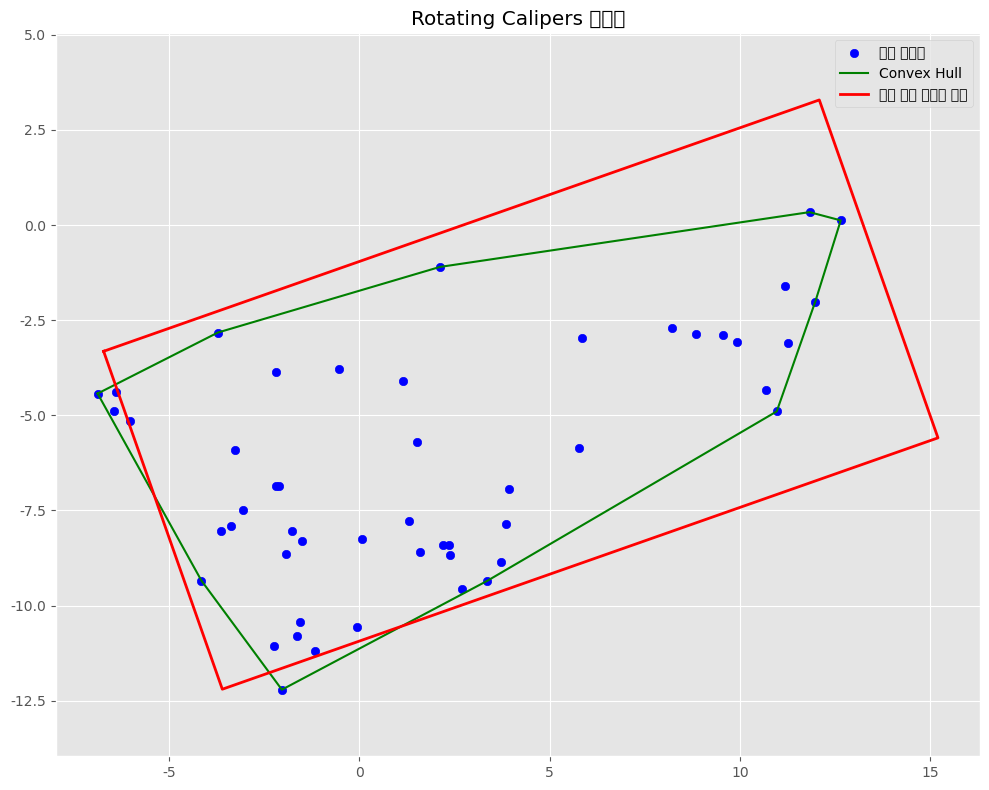

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykerne

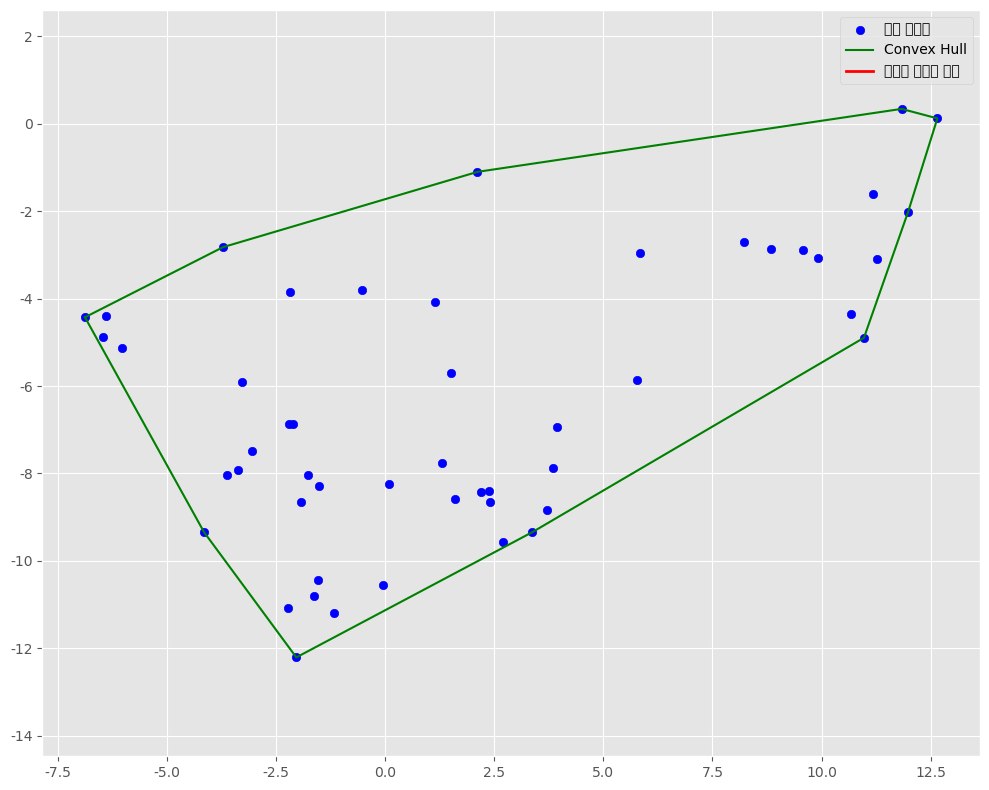

/home/shbyun/miniconda3/envs/lidar-perception/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 

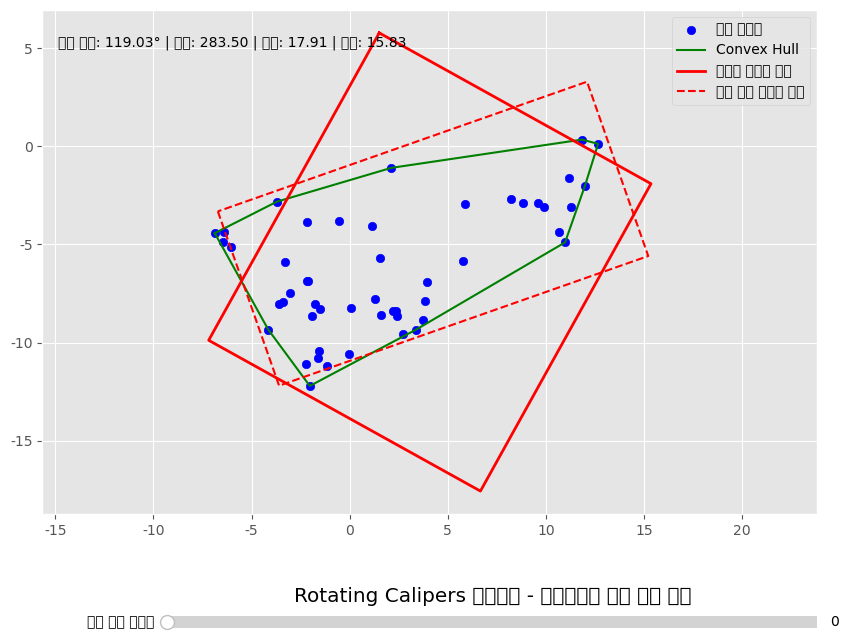

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.widgets import Slider

def compute_convex_hull(points):
    """
    points로부터 convex hull을 계산합니다.
    """
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    return hull_points

def angle_between_vectors(v1, v2):
    """
    두 벡터 사이의 각도를 계산합니다 (라디안).
    """
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(np.clip(dot_product / norm_product, -1.0, 1.0))

def rotate_points(points, angle, center=None):
    """
    points를 center 주변으로 angle만큼 회전시킵니다.
    """
    if center is None:
        center = np.mean(points, axis=0)
    
    rot_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    
    centered_points = points - center
    rotated_points = np.dot(centered_points, rot_matrix.T)
    return rotated_points + center

def compute_edge_directions(hull_points):
    """
    Convex hull의 각 에지의 방향 벡터를 계산합니다.
    """
    edges = []
    n = len(hull_points)
    
    for i in range(n):
        edge = hull_points[(i + 1) % n] - hull_points[i]
        edge_normalized = edge / np.linalg.norm(edge)
        edges.append(edge_normalized)
    
    return edges

def compute_bbox_from_hull_and_angle(hull_points, angle):
    """
    주어진 각도에서 회전된 바운딩 박스를 계산합니다.
    """
    # 각도만큼 회전
    rotated_hull = rotate_points(hull_points, angle)
    
    # 회전된 포인트의 최대/최소 좌표 찾기
    min_x = np.min(rotated_hull[:, 0])
    max_x = np.max(rotated_hull[:, 0])
    min_y = np.min(rotated_hull[:, 1])
    max_y = np.max(rotated_hull[:, 1])
    
    # 바운딩 박스의 코너 생성
    bbox_corners_rotated = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y]
    ])
    
    # 원래 방향으로 다시 회전
    bbox_corners = rotate_points(bbox_corners_rotated, -angle)
    
    # 면적 계산
    width = max_x - min_x
    height = max_y - min_y
    area = width * height
    
    return bbox_corners, area, width, height

def rotating_calipers(hull_points):
    """
    Rotating Calipers 알고리즘을 사용하여 최소 면적 바운딩 박스를 찾습니다.
    """
    edge_directions = compute_edge_directions(hull_points)
    hull_angles = [np.arctan2(direction[1], direction[0]) % np.pi for direction in edge_directions]
    
    min_area = float('inf')
    min_bbox = None
    min_angle = 0
    min_width = 0
    min_height = 0
    
    # 모든 회전 결과 저장 (시각화용)
    all_rotations = []
    
    for angle in hull_angles:
        bbox, area, width, height = compute_bbox_from_hull_and_angle(hull_points, angle)
        all_rotations.append((angle, bbox, area, width, height))
        
        if area < min_area:
            min_area = area
            min_bbox = bbox
            min_angle = angle
            min_width = width
            min_height = height
    
    return min_bbox, min_area, min_angle, min_width, min_height, all_rotations

def visualize_rotating_calipers(points, hull_points, min_bbox, all_rotations, title="Rotating Calipers 시각화"):
    """
    Rotating Calipers 알고리즘의 결과를 정적으로 시각화합니다.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title)
    
    # 원본 포인트 플롯
    ax.scatter(points[:, 0], points[:, 1], c='blue', label='원본 포인트')
    
    # Convex Hull 플롯
    hull_points_closed = np.vstack([hull_points, hull_points[0]])
    ax.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'g-', label='Convex Hull')
    
    # 최소 면적 바운딩 박스 플롯
    min_bbox_closed = np.vstack([min_bbox, min_bbox[0]])
    ax.plot(min_bbox_closed[:, 0], min_bbox_closed[:, 1], 'r-', linewidth=2, label='최소 면적 바운딩 박스')
    
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def animate_rotating_calipers(points, hull_points, all_rotations):
    """
    Rotating Calipers 알고리즘의 과정을 애니메이션으로 시각화합니다.
    """
    # 최소 면적 바운딩 박스 찾기
    min_area_idx = np.argmin([rotation[2] for rotation in all_rotations])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 원본 포인트 및 Convex Hull 플롯
    ax.scatter(points[:, 0], points[:, 1], c='blue', label='원본 포인트')
    hull_points_closed = np.vstack([hull_points, hull_points[0]])
    hull_line, = ax.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'g-', label='Convex Hull')
    
    # 바운딩 박스 초기화
    bbox_line, = ax.plot([], [], 'r-', linewidth=2, label='회전된 바운딩 박스')
    
    # 텍스트 정보 초기화
    info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, verticalalignment='top')
    
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    
    def init():
        bbox_line.set_data([], [])
        info_text.set_text('')
        return bbox_line, info_text
    
    def update(frame):
        angle, bbox, area, width, height = all_rotations[frame]
        bbox_closed = np.vstack([bbox, bbox[0]])
        bbox_line.set_data(bbox_closed[:, 0], bbox_closed[:, 1])
        
        # 최소 면적 표시
        if frame == min_area_idx:
            bbox_line.set_color('red')
            bbox_line.set_linewidth(3)
        else:
            bbox_line.set_color('orange')
            bbox_line.set_linewidth(1.5)
        
        # 정보 업데이트
        angle_deg = np.degrees(angle) % 180
        info_text.set_text(f'회전 각도: {angle_deg:.2f}° | 면적: {area:.2f} | 너비: {width:.2f} | 높이: {height:.2f}')
        
        return bbox_line, info_text
    
    ani = animation.FuncAnimation(fig, update, frames=len(all_rotations),
                                  init_func=init, blit=False, repeat=True, interval=300)
    
    plt.tight_layout()
    plt.show()
    
    return ani

def interactive_rotating_calipers(points, hull_points, all_rotations):
    """
    Rotating Calipers 알고리즘의 결과를 슬라이더로 인터랙티브하게 시각화합니다.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(bottom=0.25)  # 슬라이더 공간 확보
    
    # 원본 포인트 및 Convex Hull 플롯
    ax.scatter(points[:, 0], points[:, 1], c='blue', label='원본 포인트')
    hull_points_closed = np.vstack([hull_points, hull_points[0]])
    ax.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'g-', label='Convex Hull')
    
    # 바운딩 박스 초기화
    initial_bbox = all_rotations[0][1]
    bbox_closed = np.vstack([initial_bbox, initial_bbox[0]])
    bbox_line, = ax.plot(bbox_closed[:, 0], bbox_closed[:, 1], 'r-', linewidth=2, label='회전된 바운딩 박스')
    
    # 텍스트 정보 초기화
    info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, verticalalignment='top')
    
    # 최소 면적 바운딩 박스 찾기
    min_area_idx = np.argmin([rotation[2] for rotation in all_rotations])
    min_angle, min_bbox, min_area, min_width, min_height = all_rotations[min_area_idx]
    
    # 최소 면적 바운딩 박스 표시 (점선)
    min_bbox_closed = np.vstack([min_bbox, min_bbox[0]])
    min_bbox_line, = ax.plot(min_bbox_closed[:, 0], min_bbox_closed[:, 1], 'r--', linewidth=1.5, label='최소 면적 바운딩 박스')
    
    # 슬라이더 축 생성
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, '회전 각도 인덱스', 0, len(all_rotations) - 1, valinit=0, valstep=1)
    
    def update(val):
        idx = int(slider.val)
        angle, bbox, area, width, height = all_rotations[idx]
        
        # 바운딩 박스 업데이트
        bbox_closed = np.vstack([bbox, bbox[0]])
        bbox_line.set_data(bbox_closed[:, 0], bbox_closed[:, 1])
        
        # 정보 업데이트
        angle_deg = np.degrees(angle) % 180
        info_text.set_text(f'회전 각도: {angle_deg:.2f}° | 면적: {area:.2f} | 너비: {width:.2f} | 높이: {height:.2f}')
        
        # 최소 면적인 경우 강조
        if idx == min_area_idx:
            bbox_line.set_color('red')
            bbox_line.set_linewidth(3)
        else:
            bbox_line.set_color('orange')
            bbox_line.set_linewidth(1.5)
        
        fig.canvas.draw_idle()
    
    slider.on_changed(update)
    
    # 초기 정보 업데이트
    initial_angle, _, initial_area, initial_width, initial_height = all_rotations[0]
    angle_deg = np.degrees(initial_angle) % 180
    info_text.set_text(f'회전 각도: {angle_deg:.2f}° | 면적: {initial_area:.2f} | 너비: {initial_width:.2f} | 높이: {initial_height:.2f}')
    
    ax.legend()
    ax.axis('equal')
    ax.grid(True)
    plt.title("Rotating Calipers 알고리즘 - 슬라이더로 회전 각도 변경")
    plt.show()

def generate_sample_points(n=30, shape='random', rotation=0):
    """
    테스트용 샘플 포인트를 생성합니다.
    """
    np.random.seed(42)  # 재현성을 위한 시드 설정
    
    if shape == 'rectangle':
        # 직사각형 형태의 포인트
        width, height = 10, 5
        x = np.random.uniform(-width/2, width/2, n)
        y = np.random.uniform(-height/2, height/2, n)
        points = np.column_stack((x, y))
        
    elif shape == 'L':
        # L 형태의 포인트
        points = []
        for _ in range(n//2):
            x = np.random.uniform(-5, 5)
            y = np.random.uniform(-10, 0)
            points.append([x, y])
        for _ in range(n - n//2):
            x = np.random.uniform(-5, 15)
            y = np.random.uniform(-10, -5)
            points.append([x, y])
        points = np.array(points)
        
    else:  # random
        # 타원형 경향의 랜덤 포인트
        x = np.random.normal(0, 5, n)
        y = np.random.normal(0, 3, n)
        points = np.column_stack((x, y))
    
    # 회전 적용
    if rotation != 0:
        angle_rad = np.radians(rotation)
        points = rotate_points(points, angle_rad)
    
    return points

# 샘플 포인트 생성
shape_option = 'L'  # 'random', 'rectangle', 'L' 중 선택
rotation_angle = 30  # 회전 각도 (도)
num_points = 50

points = generate_sample_points(n=num_points, shape=shape_option, rotation=rotation_angle)

# Convex Hull 계산
hull_points = compute_convex_hull(points)

# Rotating Calipers 알고리즘 실행
min_bbox, min_area, min_angle, min_width, min_height, all_rotations = rotating_calipers(hull_points)

# 결과 출력
print(f"최소 면적 바운딩 박스:")
print(f"- 면적: {min_area:.2f}")
print(f"- 회전 각도: {np.degrees(min_angle) % 180:.2f}°")
print(f"- 너비: {min_width:.2f}")
print(f"- 높이: {min_height:.2f}")

# 정적 시각화
visualize_rotating_calipers(points, hull_points, min_bbox, all_rotations)

# 애니메이션 시각화
animate_rotating_calipers(points, hull_points, all_rotations)

# 인터랙티브 시각화
interactive_rotating_calipers(points, hull_points, all_rotations)


## 6. 3D 바운딩 박스 생성

클러스터링된 객체에 대해 3D 바운딩 박스를 생성합니다.

생성된 바운딩 박스 수: 196
박스 0: 중심=(22.92, 7.36), 크기(L,W)=(26.19, 6.03)
박스 1: 중심=(19.41, 6.52), 크기(L,W)=(0.53, 0.48)
박스 2: 중심=(22.22, 17.66), 크기(L,W)=(0.70, 0.85)
박스 3: 중심=(19.48, 18.63), 크기(L,W)=(1.84, 1.58)
박스 4: 중심=(15.21, 14.46), 크기(L,W)=(0.53, 0.14)
박스 5: 중심=(43.73, 56.26), 크기(L,W)=(2.97, 1.56)
박스 6: 중심=(31.34, 45.36), 크기(L,W)=(2.24, 0.98)
박스 7: 중심=(27.10, 42.22), 크기(L,W)=(4.36, 1.72)
박스 8: 중심=(19.45, 35.13), 크기(L,W)=(4.30, 2.18)
박스 9: 중심=(9.21, 28.30), 크기(L,W)=(13.30, 6.30)
박스 10: 중심=(6.87, 24.43), 크기(L,W)=(0.92, 0.52)
박스 11: 중심=(2.19, 32.03), 크기(L,W)=(3.65, 2.12)
박스 12: 중심=(1.28, 33.86), 크기(L,W)=(0.92, 0.39)
박스 13: 중심=(0.60, 35.52), 크기(L,W)=(1.59, 0.65)
박스 14: 중심=(-1.55, 37.53), 크기(L,W)=(2.56, 2.10)
박스 15: 중심=(-4.65, 38.70), 크기(L,W)=(4.12, 3.69)
박스 16: 중심=(-1.64, 18.36), 크기(L,W)=(0.76, 0.39)
박스 17: 중심=(-7.54, 41.93), 크기(L,W)=(1.55, 1.01)
박스 18: 중심=(-8.85, 44.51), 크기(L,W)=(1.04, 0.59)
박스 19: 중심=(-10.53, 50.08), 크기(L,W)=(0.84, 0.26)
박스 20: 중심=(-9.78, 43.28), 크기(L,W)=(1.00, 0.84)
박스 21: 중심

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

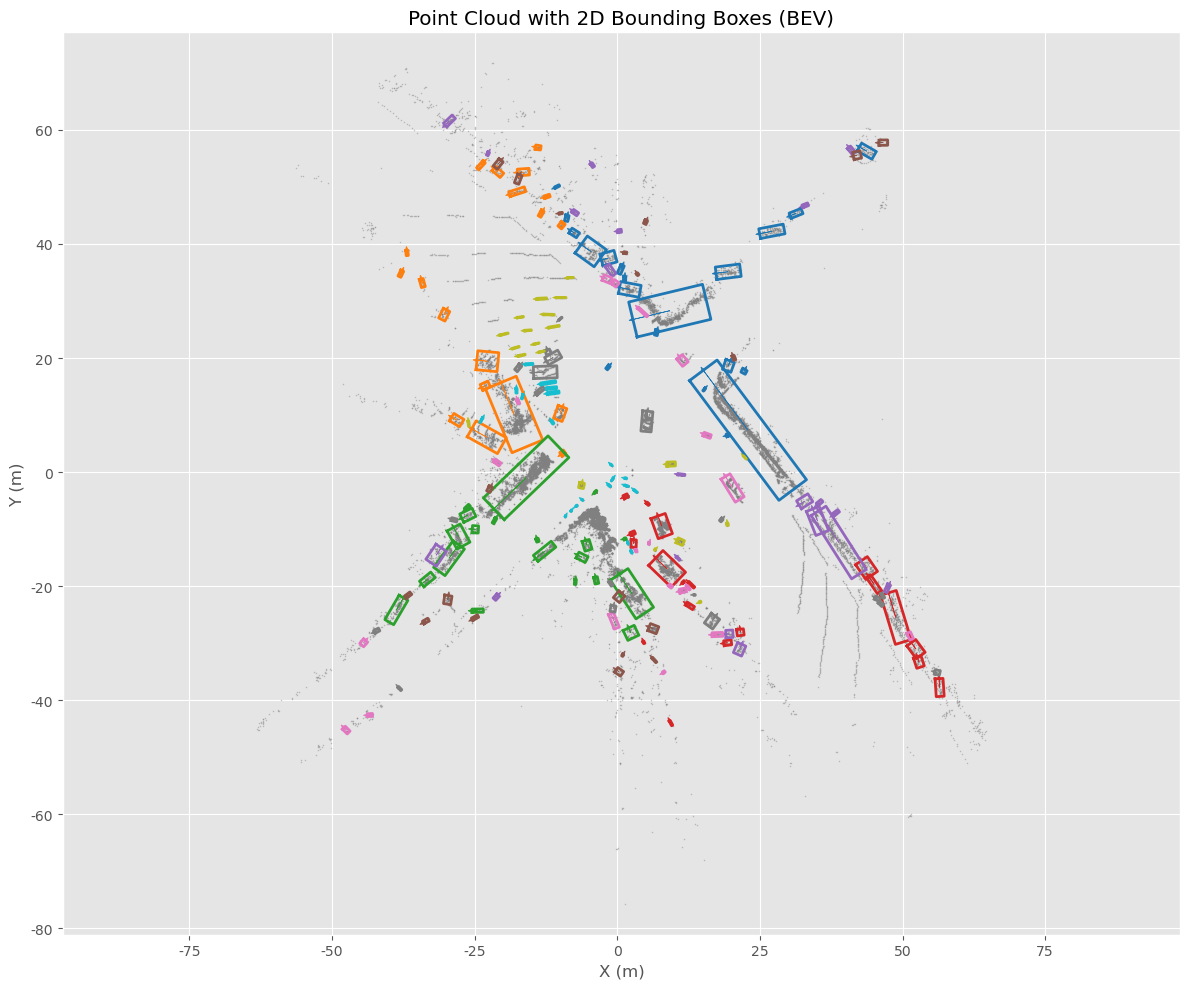

In [5]:
def compute_2d_bounding_box(points, oriented=True):
    """
    XY 평면에서 2D 바운딩 박스 계산
    
    Args:
        points (numpy.ndarray): 객체 포인트 클라우드 [N, 3+]
        oriented (bool): 방향성 바운딩 박스 여부
        
    Returns:
        dict: 바운딩 박스 정보
    """
    # XY 평면의 점만 고려
    points_2d = points[:, :2]
    
    # 방향성 바운딩 박스
    if oriented:
        # 주성분 분석 (PCA)으로 객체 방향 계산
        points_centered = points_2d - np.mean(points_2d, axis=0)
        cov = np.cov(points_centered.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # 고유값 순서대로 정렬 (오름차순)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 방향 벡터와 크기 계산
        axes = eigenvectors
        
        # 회전된 좌표계에서 포인트 표현
        points_rotated = np.dot(points_centered, axes)
        
        # 회전된 좌표계에서 축 정렬 바운딩 박스 계산
        min_bounds = np.min(points_rotated, axis=0)
        max_bounds = np.max(points_rotated, axis=0)
        
        # 바운딩 박스 크기
        dimensions = max_bounds - min_bounds
        
        # 중심점 계산
        center = np.mean(points_2d, axis=0)
        
        # Z 좌표 (높이) 통계
        min_z = np.min(points[:, 2])
        max_z = np.max(points[:, 2])
        mean_z = np.mean(points[:, 2])
        
        # 회전 행렬 (2x2)
        rotation_matrix_2d = axes
        
        # 전체 3D 공간의 중심과 크기
        center_3d = np.append(center, mean_z)
        dimensions_3d = np.append(dimensions, max_z - min_z)
        
        # 3D 회전 행렬 (방향은 XY 평면에서만 고려)
        rotation_matrix_3d = np.eye(3)
        rotation_matrix_3d[:2, :2] = rotation_matrix_2d
        
        # 2D 바운딩 박스 계산 결과
        bbox = {
            'center': center_3d,  # 3D 공간의 중심
            'dimensions': dimensions_3d,  # 박스의 길이, 폭, 높이
            'rotation_matrix': rotation_matrix_3d,  # 3D 회전 행렬
            'min_bounds_rotated': np.append(min_bounds, min_z),  # 회전 좌표계에서의 최소 경계
            'max_bounds_rotated': np.append(max_bounds, max_z),  # 회전 좌표계에서의 최대 경계
            'yaw': np.arctan2(axes[0, 1], axes[0, 0])  # 바운딩 박스의 yaw 각도
        }
    else:
        # 축 정렬 바운딩 박스
        min_bounds_2d = np.min(points_2d, axis=0)
        max_bounds_2d = np.max(points_2d, axis=0)
        
        min_z = np.min(points[:, 2])
        max_z = np.max(points[:, 2])
        
        # 바운딩 박스 크기와 중심점
        dimensions_2d = max_bounds_2d - min_bounds_2d
        center_2d = (min_bounds_2d + max_bounds_2d) / 2
        
        # 3D 공간으로 확장
        min_bounds = np.append(min_bounds_2d, min_z)
        max_bounds = np.append(max_bounds_2d, max_z)
        center = np.append(center_2d, (min_z + max_z) / 2)
        dimensions = np.append(dimensions_2d, max_z - min_z)
        
        # 바운딩 박스 정보
        bbox = {
            'center': center,
            'dimensions': dimensions,
            'min_bounds': min_bounds,
            'max_bounds': max_bounds
        }
    
    return bbox

def visualize_2d_bounding_boxes(points, bboxes, colors=None):
    """
    2D 바운딩 박스 시각화 (BEV)
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        bboxes (list): 바운딩 박스 리스트
        colors (list, optional): 바운딩 박스별 색상
        
    Returns:
        None
    """
    # 기본 색상 설정
    if colors is None:
        cmap = plt.get_cmap("tab10")
        colors = cmap(np.linspace(0, 1, len(bboxes)))
    
    # BEV 시각화
    plt.figure(figsize=(12, 10))
    
    # 포인트 클라우드 그리기 (흐리게)
    plt.scatter(points[:, 0], points[:, 1], c='gray', s=0.5, alpha=0.3)
    
    # 각 바운딩 박스 그리기
    for i, bbox in enumerate(bboxes):
        center = bbox['center']
        dimensions = bbox['dimensions']
        
        if 'rotation_matrix' in bbox:
            # 방향성 바운딩 박스
            R = bbox['rotation_matrix']
            
            # 바운딩 박스의 4개 코너 계산 (XY 평면)
            l, w = dimensions[0], dimensions[1]
            corners_local = np.array([
                [ l/2,  w/2],
                [ l/2, -w/2],
                [-l/2, -w/2],
                [-l/2,  w/2],
                [ l/2,  w/2]  # 처음 점과 연결
            ])
            
            # 회전 적용
            R_2d = R[:2, :2]
            corners_global = np.dot(corners_local, R_2d.T) + center[:2]
            
            # 바운딩 박스 그리기
            plt.plot(corners_global[:, 0], corners_global[:, 1], '-', 
                     color=colors[i][:3], linewidth=2, label=f'Box {i}')
            
            # 방향성 표시 (전면 화살표)
            front_center = center[:2] + R[:2, 0] * dimensions[0] / 2
            plt.arrow(center[0], center[1], 
                      front_center[0] - center[0], front_center[1] - center[1], 
                      head_width=0.5, head_length=0.7, fc=colors[i][:3], ec=colors[i][:3])
        else:
            # 축 정렬 바운딩 박스
            l, w = dimensions[0], dimensions[1]
            
            # 사각형 그리기
            min_x, min_y = center[0] - l/2, center[1] - w/2
            rect = plt.Rectangle((min_x, min_y), l, w, 
                                 fill=False, edgecolor=colors[i][:3], linewidth=2, label=f'Box {i}')
            plt.gca().add_patch(rect)
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Point Cloud with 2D Bounding Boxes (BEV)')
    plt.axis('equal')
    plt.grid(True)
    
    # 범례는 너무 많은 박스가 있으면 생략
    if len(bboxes) <= 10:
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 클러스터에 대해 2D 바운딩 박스 생성
bboxes = []
for cluster in clusters:
    bbox = compute_2d_bounding_box(cluster, oriented=True)
    bboxes.append(bbox)

print(f"생성된 바운딩 박스 수: {len(bboxes)}")
for i, bbox in enumerate(bboxes):
    center = bbox['center']
    dimensions = bbox['dimensions']
    print(f"박스 {i}: 중심=({center[0]:.2f}, {center[1]:.2f}), "
          f"크기(L,W)=({dimensions[0]:.2f}, {dimensions[1]:.2f})")

# 바운딩 박스 시각화
visualize_2d_bounding_boxes(non_ground_points, bboxes)


## 7. 객체 분류

클러스터링된 객체에 대해 기하학적 특성을 기반으로 객체 분류를 수행합니다.

객체 0: 클래스=unknown, 신뢰도=0.50, 위치=(22.92, 7.36)
객체 1: 클래스=pedestrian, 신뢰도=0.70, 위치=(19.41, 6.52)
객체 2: 클래스=unknown, 신뢰도=0.50, 위치=(22.22, 17.66)
객체 3: 클래스=unknown, 신뢰도=0.50, 위치=(19.48, 18.63)
객체 4: 클래스=pole, 신뢰도=0.60, 위치=(15.21, 14.46)
객체 5: 클래스=unknown, 신뢰도=0.50, 위치=(43.73, 56.26)
객체 6: 클래스=unknown, 신뢰도=0.50, 위치=(31.34, 45.36)
객체 7: 클래스=unknown, 신뢰도=0.50, 위치=(27.10, 42.22)
객체 8: 클래스=car, 신뢰도=0.80, 위치=(19.45, 35.13)
객체 9: 클래스=unknown, 신뢰도=0.50, 위치=(9.21, 28.30)
객체 10: 클래스=small_object, 신뢰도=0.50, 위치=(6.87, 24.43)
객체 11: 클래스=car, 신뢰도=0.80, 위치=(2.19, 32.03)
객체 12: 클래스=pole, 신뢰도=0.60, 위치=(1.28, 33.86)
객체 13: 클래스=unknown, 신뢰도=0.50, 위치=(0.60, 35.52)
객체 14: 클래스=unknown, 신뢰도=0.50, 위치=(-1.55, 37.53)
객체 15: 클래스=unknown, 신뢰도=0.50, 위치=(-4.65, 38.70)
객체 16: 클래스=unknown, 신뢰도=0.50, 위치=(-1.64, 18.36)
객체 17: 클래스=unknown, 신뢰도=0.50, 위치=(-7.54, 41.93)
객체 18: 클래스=unknown, 신뢰도=0.50, 위치=(-8.85, 44.51)
객체 19: 클래스=pole, 신뢰도=0.60, 위치=(-10.53, 50.08)
객체 20: 클래스=pole, 신뢰도=0.60, 위치=(-9.78, 43.28)
객체 21: 클래스=pole, 신뢰도

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

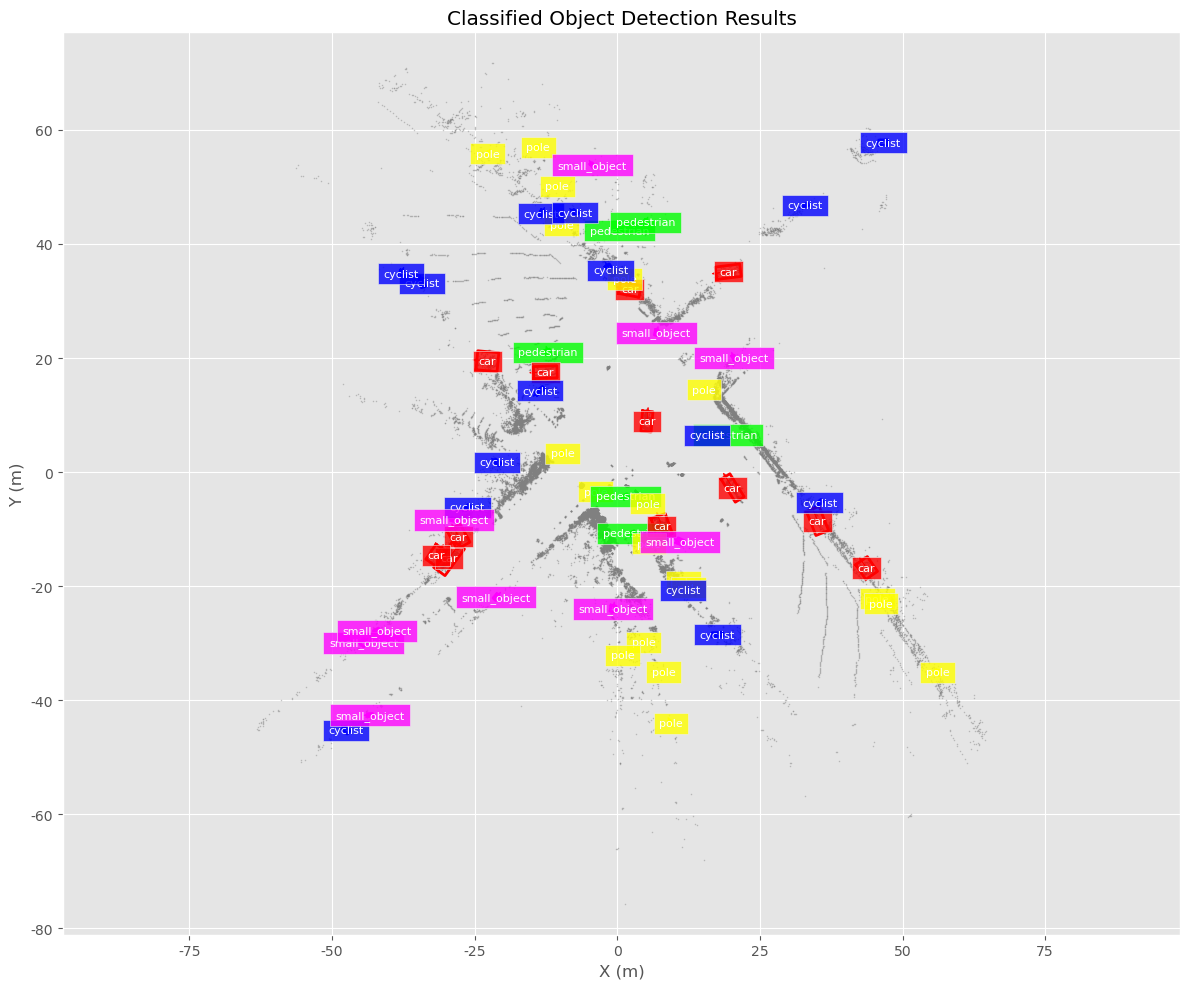

In [6]:
def extract_geometric_features(cluster, bbox):
    """
    객체의 기하학적 특징 추출
    
    Args:
        cluster (numpy.ndarray): 클러스터 포인트 [N, 3+]
        bbox (dict): 바운딩 박스 정보
        
    Returns:
        numpy.ndarray: 특징 벡터
    """
    center = bbox['center']
    dimensions = bbox['dimensions']
    
    # 길이, 폭, 높이
    l, w, h = dimensions
    
    # 1. 크기 관련 특징
    area = l * w  # XY 평면에서 면적
    perimeter = 2 * (l + w)  # XY 평면에서 둘레
    compactness = (perimeter**2) / (4 * np.pi * area)  # 원에 대해 최소화됨
    
    # 2. 형태 관련 특징
    length_width_ratio = l / max(w, 1e-6)
    elongation = max(l, w) / min(l, w)
    
    # 3. 포인트 분포 관련 특징
    point_density = len(cluster) / area
    
    # 4. 상대적 위치 관련 특징
    distance_to_origin = np.linalg.norm(center[:2])  # XY 평면에서 원점까지 거리
    height_from_ground = np.min(cluster[:, 2])  # 최소 z 좌표 (지면으로부터 높이)
    height_range = np.max(cluster[:, 2]) - np.min(cluster[:, 2])  # 높이 범위
    
    # 5. 고유값 기반 특징
    if 'rotation_matrix' in bbox:
        # 이미 PCA 결과를 가지고 있음
        eigenvalues = dimensions[:2]**2 / 4  # 간단한 추정
    else:
        # PCA 계산
        points_centered = cluster[:, :2] - np.mean(cluster[:, :2], axis=0)
        cov = np.cov(points_centered.T)
        eigenvalues, _ = np.linalg.eigh(cov)
        eigenvalues = eigenvalues[::-1]  # 내림차순 정렬
    
    # 고유값 기반 특징 (XY 평면에만 해당)
    linearity = (eigenvalues[0] - eigenvalues[1]) / max(eigenvalues[0], 1e-6)
    
    # 6. 강도 관련 특징 (있는 경우)
    if cluster.shape[1] >= 4:
        mean_intensity = np.mean(cluster[:, 3])
        std_intensity = np.std(cluster[:, 3])
    else:
        mean_intensity = 0
        std_intensity = 0
    
    # 모든 특징을 하나의 벡터로 결합
    features = np.array([
        l, w, h,                           # 크기
        area, perimeter, compactness,      # 크기 관련 (XY 평면)
        length_width_ratio, elongation,    # 형태 (XY 평면)
        point_density,                     # 포인트 분포
        distance_to_origin, height_from_ground, height_range,  # 위치
        linearity,                         # 고유값 기반
        mean_intensity, std_intensity      # 강도 관련
    ])
    
    return features

def classify_object(features):
    """
    특징 벡터를 기반으로 객체 분류
    
    Args:
        features (numpy.ndarray): 특징 벡터
        
    Returns:
        tuple: (클래스, 신뢰도)
    """
    # 특징 추출
    l, w, h = features[:3]
    area = features[3]
    length_width_ratio = features[6]
    elongation = features[7]
    point_density = features[8]
    height_from_ground = features[10]
    height_range = features[11]
    
    # 간단한 규칙 기반 분류
    confidence = 0.0
    
    # 차량 (자동차, 트럭 등)
    if 3.0 < l < 12.0 and 1.5 < w < 3.5 and height_range < 3.0:
        if l > 6.0 and height_range > 2.0:
            # 트럭/버스
            obj_class = 'truck'
            confidence = 0.7
        else:
            # 자동차
            obj_class = 'car'
            confidence = 0.8
    
    # 보행자
    elif 0.4 < l < 1.0 and 0.4 < w < 1.0 and 1.0 < height_range < 2.2:
        if length_width_ratio < 1.5 and elongation < 1.5:
            obj_class = 'pedestrian'
            confidence = 0.7
        else:
            obj_class = 'small_object'
            confidence = 0.5
    
    # 자전거/이륜차
    elif 1.0 < l < 2.5 and 0.4 < w < 1.0 and 0.8 < height_range < 2.0:
        if length_width_ratio > 1.5:
            obj_class = 'cyclist'
            confidence = 0.6
        else:
            obj_class = 'small_object'
            confidence = 0.5
    
    # 표지판, 전봇대 등 수직 구조물
    elif height_range > 1.5 and l < 1.0 and w < 1.0:
        obj_class = 'pole'
        confidence = 0.6
    
    # 기타 장애물
    else:
        obj_class = 'unknown'
        confidence = 0.5
    
    return obj_class, confidence

# 각 클러스터에 대해 특징 추출 및 분류 수행
object_results = []

for i, (cluster, bbox) in enumerate(zip(clusters, bboxes)):
    # 특징 추출
    features = extract_geometric_features(cluster, bbox)
    
    # 객체 분류
    obj_class, confidence = classify_object(features)
    
    # 결과 저장
    result = {
        'id': i,
        'class': obj_class,
        'confidence': confidence,
        'center': bbox['center'],
        'dimensions': bbox['dimensions'],
        'bbox': bbox,
        'features': features
    }
    
    object_results.append(result)
    
    print(f"객체 {i}: 클래스={obj_class}, 신뢰도={confidence:.2f}, "
          f"위치=({bbox['center'][0]:.2f}, {bbox['center'][1]:.2f})")

# 분류 결과 시각화 (unknown 클래스 제외)
# 클래스별 색상 정의
class_colors = {
    'car': [1, 0, 0],       # 빨강
    'truck': [0.8, 0, 0],   # 어두운 빨강
    'pedestrian': [0, 1, 0], # 초록
    'cyclist': [0, 0, 1],   # 파랑
    'pole': [1, 1, 0],      # 노랑
    'small_object': [1, 0, 1] # 마젠타
}

# unknown 클래스 제외한 객체만 필터링
filtered_object_results = [obj for obj in object_results if obj['class'] != 'unknown']
filtered_bboxes = [obj['bbox'] for obj in filtered_object_results]

# 바운딩 박스 색상 설정
bbox_colors = []
for result in filtered_object_results:
    bbox_colors.append(class_colors.get(result['class'], [0.5, 0.5, 0.5]))

# 클래스 정보가 포함된 바운딩 박스 시각화
plt.figure(figsize=(12, 10))
plt.scatter(non_ground_points[:, 0], non_ground_points[:, 1], c='gray', s=0.5, alpha=0.3)

# 각 객체의 바운딩 박스 그리기
for i, (bbox, color) in enumerate(zip(filtered_bboxes, bbox_colors)):
    center = bbox['center']
    dimensions = bbox['dimensions']
    obj_class = filtered_object_results[i]['class']
    
    if 'rotation_matrix' in bbox:
        # 방향성 바운딩 박스
        R = bbox['rotation_matrix']
        
        # 바운딩 박스의 4개 코너 계산 (XY 평면)
        l, w = dimensions[0], dimensions[1]
        corners_local = np.array([
            [ l/2,  w/2],
            [ l/2, -w/2],
            [-l/2, -w/2],
            [-l/2,  w/2],
            [ l/2,  w/2]  # 처음 점과 연결
        ])
        
        # 회전 적용
        R_2d = R[:2, :2]
        corners_global = np.dot(corners_local, R_2d.T) + center[:2]
        
        # 바운딩 박스 그리기
        plt.plot(corners_global[:, 0], corners_global[:, 1], '-', 
                 color=color, linewidth=2)
        
        # 방향성 표시 (전면 화살표)
        front_center = center[:2] + R[:2, 0] * dimensions[0] / 2
        plt.arrow(center[0], center[1], 
                  front_center[0] - center[0], front_center[1] - center[1], 
                  head_width=0.5, head_length=0.7, fc=color, ec=color)
    else:
        # 축 정렬 바운딩 박스
        l, w = dimensions[0], dimensions[1]
        
        # 사각형 그리기
        min_x, min_y = center[0] - l/2, center[1] - w/2
        rect = plt.Rectangle((min_x, min_y), l, w, 
                             fill=False, edgecolor=color, linewidth=2)
        plt.gca().add_patch(rect)
    
    # 클래스 레이블 추가
    plt.text(center[0], center[1], obj_class, 
             color='white', fontsize=8, 
             bbox=dict(facecolor=color, alpha=0.8),
             ha='center', va='center')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Classified Object Detection Results')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. 이미지에 3D 바운딩 박스 투영

3D 객체 검출 결과를 2D 이미지에 투영하여 시각화합니다.



findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


객체 1 투영 오류 발생
객체 4 투영 오류 발생
객체 8 투영 오류 발생
객체 10 투영 오류 발생
객체 11 투영 오류 발생
객체 12 투영 오류 발생
객체 19 투영 오류 발생
객체 20 투영 오류 발생
객체 21 투영 오류 발생
객체 23 투영 오류 발생
객체 30 투영 오류 발생
객체 32 투영 오류 발생
객체 33 투영 오류 발생
객체 36 투영 오류 발생
객체 40 투영 오류 발생
객체 44 투영 오류 발생
객체 45 투영 오류 발생
객체 49 투영 오류 발생
객체 59 투영 오류 발생
객체 60 투영 오류 발생
객체 62 투영 오류 발생
객체 63 투영 오류 발생
객체 66 투영 오류 발생
객체 70 투영 오류 발생
객체 71 투영 오류 발생
객체 77 투영 오류 발생
객체 79 투영 오류 발생
객체 84 투영 오류 발생
객체 85 투영 오류 발생
객체 86 투영 오류 발생
객체 87 투영 오류 발생
객체 88 투영 오류 발생
객체 89 투영 오류 발생
객체 91 투영 오류 발생
객체 92 투영 오류 발생
객체 97 투영 오류 발생
객체 107 투영 오류 발생
객체 109 투영 오류 발생
객체 110 투영 오류 발생
객체 112 투영 오류 발생
객체 117 투영 오류 발생
객체 118 투영 오류 발생
객체 119 투영 오류 발생
객체 123 투영 오류 발생
객체 124 투영 오류 발생
객체 125 투영 오류 발생
객체 127 투영 오류 발생
객체 128 투영 오류 발생
객체 131 투영 오류 발생
객체 132 투영 오류 발생
객체 136 투영 오류 발생
객체 138 투영 오류 발생
객체 140 투영 오류 발생
객체 143 투영 오류 발생
객체 146 투영 오류 발생
객체 148 투영 오류 발생
객체 149 투영 오류 발생
객체 150 투영 오류 발생
객체 152 투영 오류 발생
객체 153 투영 오류 발생
객체 154 투영 오류 발생
객체 159 투영 오류 발생


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


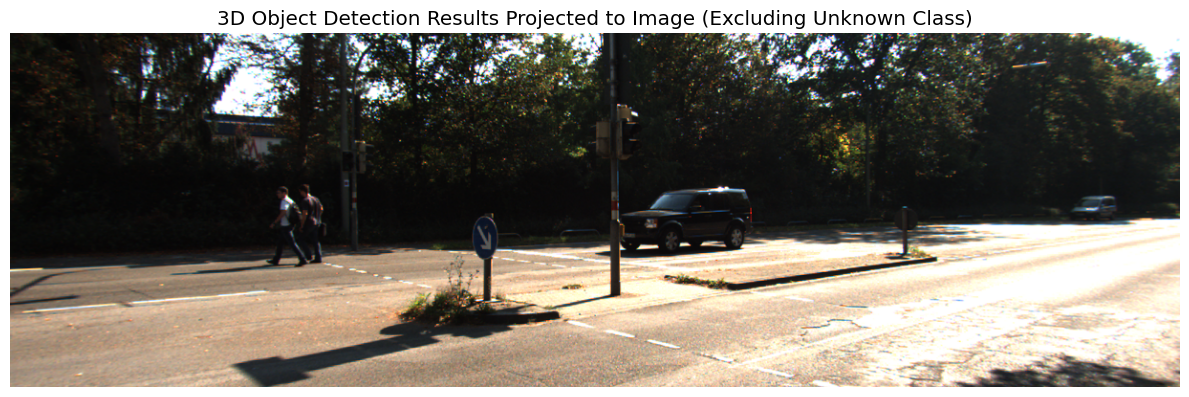

In [7]:
# # %%
# def project_3d_bbox_to_image(bbox, calib_data):
#     """
#     3D 바운딩 박스를 이미지 평면에 투영
    
#     Args:
#         bbox (dict): 3D 바운딩 박스 정보
#         calib_data (dict): 캘리브레이션 데이터
        
#     Returns:
#         numpy.ndarray: 이미지 평면에 투영된 바운딩 박스 코너 [8, 2]
#     """
#     center = bbox['center']
#     dimensions = bbox['dimensions']
    
#     # 박스의 8개 코너 계산
#     l, w, h = dimensions
    
#     # 방향성 바운딩 박스인 경우
#     if 'rotation_matrix' in bbox:
#         R = bbox['rotation_matrix']
#     else:
#         # 축 정렬 바운딩 박스인 경우
#         R = np.eye(3)
    
#     # 로컬 좌표계에서 코너 계산
#     corners_local = np.array([
#         [ l/2,  w/2,  h/2],  # 0: 오른쪽 위 앞
#         [ l/2, -w/2,  h/2],  # 1: 왼쪽 위 앞
#         [-l/2, -w/2,  h/2],  # 2: 왼쪽 위 뒤
#         [-l/2,  w/2,  h/2],  # 3: 오른쪽 위 뒤
#         [ l/2,  w/2, -h/2],  # 4: 오른쪽 아래 앞
#         [ l/2, -w/2, -h/2],  # 5: 왼쪽 아래 앞
#         [-l/2, -w/2, -h/2],  # 6: 왼쪽 아래 뒤
#         [-l/2,  w/2, -h/2]   # 7: 오른쪽 아래 뒤
#     ])
    
#     # 회전 및 이동 적용
#     corners_global = np.dot(corners_local, R.T) + center
    
#     # LiDAR 좌표계에서 카메라 좌표계로 변환
#     corners_cam = lidar_to_camera(corners_global, calib_data)
    
#     # 카메라 좌표계에서 이미지 평면으로 투영
#     corners_img = camera_to_image(corners_cam, calib_data)
    
#     return corners_img

# def draw_3d_bbox_on_image(image, corners_img, color=(0, 255, 0), thickness=2, draw_lines=True):
#     """
#     이미지에 3D 바운딩 박스 투영 결과 그리기
    
#     Args:
#         image (numpy.ndarray): 이미지
#         corners_img (numpy.ndarray): 투영된 바운딩 박스 코너 [8, 2]
#         color (tuple): 색상 (BGR)
#         thickness (int): 선 두께
#         draw_lines (bool): 코너 연결선 그리기 여부
        
#     Returns:
#         numpy.ndarray: 바운딩 박스가 그려진 이미지
#     """
#     img = image.copy()
    
#     # 코너 좌표를 정수로 변환
#     corners = corners_img.astype(np.int32)
    
#     # 코너 그리기
#     for corner in corners:
#         cv2.circle(img, tuple(corner), 3, color, -1)
    
#     if draw_lines:
#         # 바닥면 연결
#         cv2.line(img, tuple(corners[4]), tuple(corners[5]), color, thickness)
#         cv2.line(img, tuple(corners[5]), tuple(corners[6]), color, thickness)
#         cv2.line(img, tuple(corners[6]), tuple(corners[7]), color, thickness)
#         cv2.line(img, tuple(corners[7]), tuple(corners[4]), color, thickness)
        
#         # 천장면 연결
#         cv2.line(img, tuple(corners[0]), tuple(corners[1]), color, thickness)
#         cv2.line(img, tuple(corners[1]), tuple(corners[2]), color, thickness)
#         cv2.line(img, tuple(corners[2]), tuple(corners[3]), color, thickness)
#         cv2.line(img, tuple(corners[3]), tuple(corners[0]), color, thickness)
        
#         # 기둥 연결
#         cv2.line(img, tuple(corners[0]), tuple(corners[4]), color, thickness)
#         cv2.line(img, tuple(corners[1]), tuple(corners[5]), color, thickness)
#         cv2.line(img, tuple(corners[2]), tuple(corners[6]), color, thickness)
#         cv2.line(img, tuple(corners[3]), tuple(corners[7]), color, thickness)
    
#     return img

# # 객체 검출 결과를 이미지에 투영
# projected_results = []

# for result in object_results:
#     bbox = result['bbox']
#     obj_class = result['class']
#     confidence = result['confidence']
    
#     # 3D 바운딩 박스 이미지 투영
#     try:
#         corners_img = project_3d_bbox_to_image(bbox, calib_data)
        
#         # 투영 결과 저장
#         projected_result = {
#             'id': result['id'],
#             'class': obj_class,
#             'confidence': confidence,
#             'corners_img': corners_img,
#             'bbox': bbox
#         }
        
#         projected_results.append(projected_result)
#     except:
#         print(f"객체 {result['id']} 투영 오류 발생")

# # 결과 시각화
# img_result = image.copy()

# for result in projected_results:
#     obj_class = result['class']
#     confidence = result['confidence']
#     corners_img = result['corners_img']
    
#     # 클래스별 색상 설정
#     color_rgb = class_colors.get(obj_class, [0.5, 0.5, 0.5])
#     color_bgr = (int(color_rgb[2]*255), int(color_rgb[1]*255), int(color_rgb[0]*255))
    
#     # 바운딩 박스 그리기
#     img_result = draw_3d_bbox_on_image(img_result, corners_img, color=color_bgr)
    
#     # 레이블 추가
#     # 바운딩 박스 중심 계산
#     center_x = np.mean(corners_img[:, 0])
#     center_y = np.min(corners_img[:, 1])  # 상단
    
#     label = f"{obj_class} {confidence:.2f}"
#     cv2.putText(img_result, label, (int(center_x), int(center_y)), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)
# # 결과 표시
# plt.figure(figsize=(12, 8))
# plt.imshow(img_result)
# plt.title('3D Object Detection Results Projected to Image')
# plt.axis('off')
# plt.tight_layout()
# plt.show()
# 객체 검출 결과를 이미지에 투영 ('unknown' 클래스 제외)
projected_results = []

for result in object_results:
    bbox = result['bbox']
    obj_class = result['class']
    confidence = result['confidence']
    
    # 'unknown' 클래스 제외
    if obj_class == 'unknown':
        continue
    
    # 3D 바운딩 박스 이미지 투영
    try:
        corners_img = project_3d_bbox_to_image(bbox, calib_data)
        
        # 투영 결과 저장
        projected_result = {
            'id': result['id'],
            'class': obj_class,
            'confidence': confidence,
            'corners_img': corners_img,
            'bbox': bbox
        }
        
        projected_results.append(projected_result)
    except:
        print(f"객체 {result['id']} 투영 오류 발생")

# 결과 시각화
img_result = image.copy()

for result in projected_results:
    obj_class = result['class']
    confidence = result['confidence']
    corners_img = result['corners_img']
    
    # 클래스별 색상 설정
    color_rgb = class_colors.get(obj_class, [0.5, 0.5, 0.5])
    color_bgr = (int(color_rgb[2]*255), int(color_rgb[1]*255), int(color_rgb[0]*255))
    
    # 바운딩 박스 그리기
    img_result = draw_3d_bbox_on_image(img_result, corners_img, color=color_bgr)
    
    # 레이블 추가
    # 바운딩 박스 중심 계산
    center_x = np.mean(corners_img[:, 0])
    center_y = np.min(corners_img[:, 1])  # 상단
    
    label = f"{obj_class} {confidence:.2f}"
    cv2.putText(img_result, label, (int(center_x), int(center_y)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)

# 결과 표시
plt.figure(figsize=(12, 8))
plt.imshow(img_result)
plt.title('3D Object Detection Results Projected to Image (Excluding Unknown Class)')
plt.axis('off')
plt.tight_layout()
plt.show()

## 9. 딥러닝 기반 객체 검출

딥러닝 모델을 사용한 포인트 클라우드 기반 객체 검출 방법을 알아봅니다.

In [14]:
# 간단한 PointNet 스타일 네트워크 구현
class SimplePointNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=4):
        super(SimplePointNet, self).__init__()
        
        # 포인트 특징 추출 네트워크
        self.conv1 = nn.Conv1d(input_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        
        # 배치 정규화 레이어
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        # 분류 헤드
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # x: (batch_size, input_channels, num_points)
        
        # 포인트 특징 추출
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # 글로벌 풀링
        x = torch.max(x, dim=2, keepdim=False)[0]
        
        # 분류
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

def preprocess_points_for_pointnet(points, num_points=1024):
    """
    포인트 클라우드를 PointNet 입력 형식으로 전처리
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        num_points (int): 샘플링할 포인트 수
        
    Returns:
        numpy.ndarray: 전처리된 포인트 클라우드 [3, num_points]
    """
    # 좌표만 추출
    xyz = points[:, :3]
    
    # 중심 이동
    center = np.mean(xyz, axis=0)
    xyz = xyz - center
    
    # 크기 정규화
    max_dist = np.max(np.sqrt(np.sum(xyz**2, axis=1)))
    xyz = xyz / max_dist
    
    # 포인트 샘플링
    if len(xyz) >= num_points:
        # 무작위 샘플링
        idx = np.random.choice(len(xyz), num_points, replace=False)
    else:
        # 반복 샘플링
        idx = np.random.choice(len(xyz), num_points, replace=True)
    
    xyz_sampled = xyz[idx]
    
    # 차원 변환 (PointNet 입력 형식: [채널, 포인트])
    xyz_sampled = xyz_sampled.T
    
    return xyz_sampled

# 모델 학습 및 평가 함수
def train_and_evaluate_model(clusters, labels, test_size=0.3):
    """
    PointNet 모델 학습 및 평가
    
    Args:
        clusters (list): 클러스터 리스트
        labels (list): 클래스 레이블 리스트
        test_size (float): 테스트 데이터 비율
        
    Returns:
        SimplePointNet: 학습된 모델
    """
    # 클래스 매핑
    class_to_idx = {'car': 0, 'pedestrian': 1, 'cyclist': 2, 'other': 3}
    
    # 레이블 인덱스 변환
    label_indices = [class_to_idx.get(label, 3) for label in labels]
    
    # 데이터 전처리
    processed_data = []
    for cluster in clusters:
        processed = preprocess_points_for_pointnet(cluster)
        processed_data.append(processed)
    
    # 데이터 분할 (학습/테스트)
    n_samples = len(processed_data)
    n_test = int(n_samples * test_size)
    
    # 무작위 인덱스 생성
    indices = np.random.permutation(n_samples)
    test_idx, train_idx = indices[:n_test], indices[n_test:]
    
    # 학습/테스트 데이터 분리
    train_data = [processed_data[i] for i in train_idx]
    train_labels = [label_indices[i] for i in train_idx]
    test_data = [processed_data[i] for i in test_idx]
    test_labels = [label_indices[i] for i in test_idx]
    
    # PyTorch 텐서로 변환
    train_data = torch.FloatTensor(np.array(train_data))
    train_labels = torch.LongTensor(np.array(train_labels))
    test_data = torch.FloatTensor(np.array(test_data))
    test_labels = torch.LongTensor(np.array(test_labels))
    
    # 모델 초기화
    model = SimplePointNet(input_channels=3, num_classes=4)
    
    # 손실 함수 및 옵티마이저
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 학습
    num_epochs = 20
    batch_size = 8
    
    for epoch in range(num_epochs):
        model.train()
        
        # 배치 처리
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i+batch_size]
            batch_labels = train_labels[i:i+batch_size]
            
            # 순전파
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            
            # 역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 평가
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_data)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == test_labels).sum().item() / len(test_labels)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # 최종 평가
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == test_labels).sum().item() / len(test_labels)
    
    print(f"\n최종 테스트 정확도: {accuracy:.4f}")
    
    return model

# 데이터 생성 (학습 시뮬레이션 용)
def create_synthetic_data():
    """
    학습용 합성 데이터 생성
    
    Returns:
        tuple: (클러스터, 레이블)
    """
    synthetic_clusters = []
    synthetic_labels = []
    
    # 차량 데이터 생성
    for _ in range(20):
        # 차량 크기
        l = np.random.uniform(3.5, 5.0)
        w = np.random.uniform(1.5, 2.0)
        h = np.random.uniform(1.4, 1.8)
        
        # 무작위 포인트 생성 (차량 형태)
        num_points = np.random.randint(100, 200)
        x = np.random.uniform(-l/2, l/2, num_points)
        y = np.random.uniform(-w/2, w/2, num_points)
        z = np.random.uniform(-h/2, h/2, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('car')
    
    # 보행자 데이터 생성
    for _ in range(15):
        # 보행자 크기
        w = np.random.uniform(0.4, 0.6)
        d = np.random.uniform(0.4, 0.6)
        h = np.random.uniform(1.5, 1.9)
        
        # 무작위 포인트 생성 (보행자 형태)
        num_points = np.random.randint(50, 100)
        x = np.random.uniform(-w/2, w/2, num_points)
        y = np.random.uniform(-d/2, d/2, num_points)
        z = np.random.uniform(0, h, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('pedestrian')
    
    # 자전거 데이터 생성
    for _ in range(10):
        # 자전거 크기
        l = np.random.uniform(1.5, 2.0)
        w = np.random.uniform(0.5, 0.7)
        h = np.random.uniform(1.2, 1.8)
        
        # 무작위 포인트 생성 (자전거 형태)
        num_points = np.random.randint(70, 150)
        x = np.random.uniform(-l/2, l/2, num_points)
        y = np.random.uniform(-w/2, w/2, num_points)
        z = np.random.uniform(0, h, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('cyclist')
    
    # 기타 객체 데이터 생성
    for _ in range(15):
        # 무작위 크기
        s1 = np.random.uniform(0.5, 2.0)
        s2 = np.random.uniform(0.5, 2.0)
        s3 = np.random.uniform(0.5, 2.0)
        
        # 무작위 포인트 생성 (임의 형태)
        num_points = np.random.randint(30, 100)
        x = np.random.uniform(-s1/2, s1/2, num_points)
        y = np.random.uniform(-s2/2, s2/2, num_points)
        z = np.random.uniform(-s3/2, s3/2, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('other')
    
    return synthetic_clusters, synthetic_labels

# 합성 데이터 생성 및 모델 학습 (시뮬레이션)
try:
    print("합성 데이터로 PointNet 학습 시뮬레이션 (학습 목적)")
    synthetic_clusters, synthetic_labels = create_synthetic_data()
    
    # 학습 데이터 크기
    print(f"합성 데이터 크기: {len(synthetic_clusters)} 객체")
    
    # 클래스별 개수
    class_counts = {}
    for label in synthetic_labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    print("클래스별 개수:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    
    # 모델 학습 및 평가
    model = train_and_evaluate_model(synthetic_clusters, synthetic_labels)
    
    # 실제 클러스터에 모델 적용 (시뮬레이션)
    print("\n검출된 클러스터에 모델 적용 (시뮬레이션)")
    
    class_idx_to_name = {0: 'car', 1: 'pedestrian', 2: 'cyclist', 3: 'other'}
    
    # 클러스터 전처리 및 예측
    model.eval()
    dl_predictions = []
    
    for i, cluster in enumerate(clusters):
        if len(cluster) < 10:
            continue
            
        # 포인트 전처리
        processed = preprocess_points_for_pointnet(cluster)
        processed_tensor = torch.FloatTensor(processed).unsqueeze(0)  # 배치 차원 추가
        
        # 예측
        with torch.no_grad():
            outputs = model(processed_tensor)
            _, predicted = torch.max(outputs, 1)
            
            pred_idx = predicted.item()
            pred_class = class_idx_to_name[pred_idx]
            confidence = F.softmax(outputs, dim=1)[0, pred_idx].item()
        
        print(f"클러스터 {i}: 예측 클래스={pred_class}, 신뢰도={confidence:.4f}")
        
        # 예측 결과 저장
        dl_predictions.append({
            'id': i,
            'class': pred_class,
            'confidence': confidence,
            'bbox': bboxes[i] if i < len(bboxes) else None
        })
    
    # 규칙 기반과 딥러닝 결과 비교 시각화
    if dl_predictions:
        print("\n규칙 기반 vs. 딥러닝 분류 결과 비교:")
        
        for i, (rule_result, dl_result) in enumerate(zip(object_results, dl_predictions)):
            if i >= len(object_results) or i >= len(dl_predictions):
                break
                
            rule_class = rule_result['class']
            dl_class = dl_result['class']
            
            print(f"객체 {i}: 규칙 기반={rule_class}, 딥러닝={dl_class}")
except Exception as e:
    print(f"딥러닝 모델 학습 및 적용 중 오류 발생: {e}")
    print("실제 환경에서는 사전 학습된 모델 로드가 필요합니다.")

합성 데이터로 PointNet 학습 시뮬레이션 (학습 목적)
합성 데이터 크기: 60 객체
클래스별 개수:
  car: 20
  pedestrian: 15
  cyclist: 10
  other: 15
Epoch 1/20, Loss: 1.1088, Accuracy: 0.1111
Epoch 2/20, Loss: 0.8183, Accuracy: 0.3333
Epoch 3/20, Loss: 1.1030, Accuracy: 0.3333
Epoch 4/20, Loss: 0.4034, Accuracy: 0.3333
Epoch 5/20, Loss: 0.3492, Accuracy: 0.7222
Epoch 6/20, Loss: 0.4136, Accuracy: 0.7222
Epoch 7/20, Loss: 0.5239, Accuracy: 0.8889
Epoch 8/20, Loss: 0.2866, Accuracy: 0.8889
Epoch 9/20, Loss: 0.4276, Accuracy: 0.8889
Epoch 10/20, Loss: 0.4183, Accuracy: 0.9444
Epoch 11/20, Loss: 0.2320, Accuracy: 0.9444
Epoch 12/20, Loss: 0.3461, Accuracy: 0.9444
Epoch 13/20, Loss: 0.2149, Accuracy: 0.9444
Epoch 14/20, Loss: 0.2998, Accuracy: 0.9444
Epoch 15/20, Loss: 0.1143, Accuracy: 0.9444
Epoch 16/20, Loss: 0.1024, Accuracy: 0.9444
Epoch 17/20, Loss: 0.1197, Accuracy: 0.9444
Epoch 18/20, Loss: 0.0939, Accuracy: 0.9444
Epoch 19/20, Loss: 0.1261, Accuracy: 0.9444
Epoch 20/20, Loss: 0.1253, Accuracy: 0.9444

최종 테스트 정확도: 0.9

## 10. 센서 융합 기반 객체 검출

LiDAR와 카메라 데이터를 융합하여 더 정확한 객체 검출을 수행합니다.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


2D 검출 수: 10
3D 검출 수: 196


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


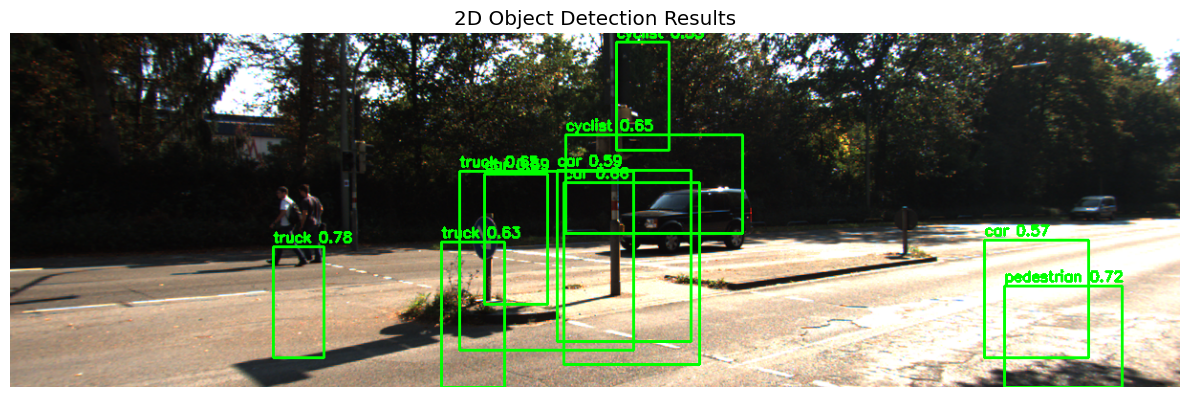

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


융합 검출 수: 81
소스별 검출 수:
  3d: 71
  2d: 10


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


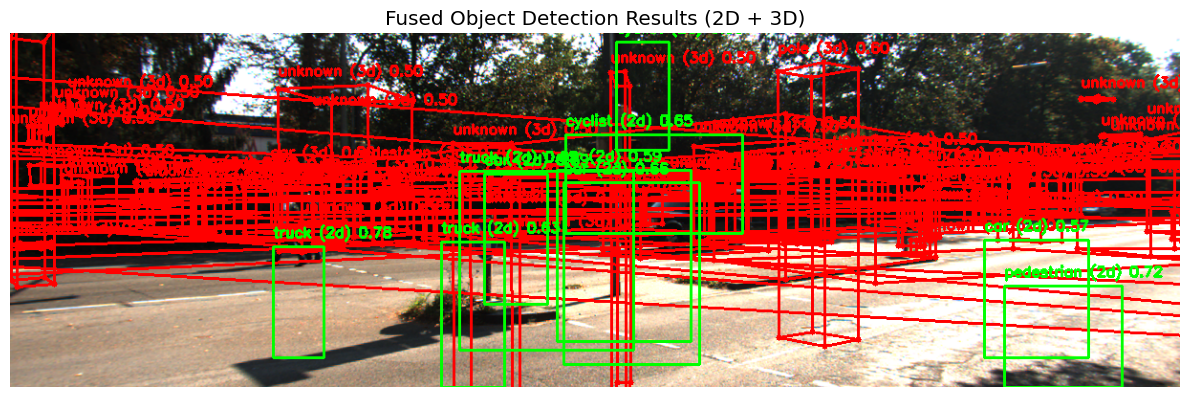

In [15]:
# 이미지 기반 객체 검출 결과 시뮬레이션
def simulate_2d_detection(image):
    """
    2D 객체 검출 결과 시뮬레이션 (실제로는 사전 학습된 모델 사용)
    
    Args:
        image (numpy.ndarray): 입력 이미지
        
    Returns:
        list: 2D 바운딩 박스 리스트 [x_min, y_min, x_max, y_max, class, confidence]
    """
    height, width = image.shape[:2]
    detections_2d = []
    
    # 무작위 박스 생성 (시뮬레이션 목적)
    for _ in range(10):
        # 무작위 바운딩 박스
        x_min = np.random.randint(0, width - 100)
        y_min = np.random.randint(0, height - 100)
        box_w = np.random.randint(50, 200)
        box_h = np.random.randint(50, 200)
        x_max = min(x_min + box_w, width)
        y_max = min(y_min + box_h, height)
        
        # 무작위 클래스 및 신뢰도
        classes = ['car', 'pedestrian', 'cyclist', 'truck']
        class_id = np.random.randint(0, len(classes))
        class_name = classes[class_id]
        confidence = np.random.uniform(0.5, 0.9)
        
        detections_2d.append([x_min, y_min, x_max, y_max, class_name, confidence])
    
    return detections_2d

def fuse_2d_3d_detections(detections_2d, detections_3d, calib_data, image_shape, iou_threshold=0.5):
    """
    2D와 3D 객체 검출 결과 융합
    
    Args:
        detections_2d (list): 2D 검출 결과 [x_min, y_min, x_max, y_max, class, confidence]
        detections_3d (list): 3D 검출 결과 딕셔너리
        calib_data (dict): 캘리브레이션 데이터
        image_shape (tuple): 이미지 크기 (height, width)
        iou_threshold (float): 융합을 위한 IoU 임계값
        
    Returns:
        list: 융합된 검출 결과
    """
    fused_detections = []
    used_2d_indices = set()
    used_3d_indices = set()
    
    # 각 3D 검출을 2D 이미지에 투영
    for i, det_3d in enumerate(detections_3d):
        if 'bbox' not in det_3d:
            continue
            
        # 3D 바운딩 박스 이미지 투영
        try:
            corners_img = project_3d_bbox_to_image(det_3d['bbox'], calib_data)
            
            # 2D 바운딩 박스 계산
            min_x = max(0, int(np.min(corners_img[:, 0])))
            min_y = max(0, int(np.min(corners_img[:, 1])))
            max_x = min(image_shape[1], int(np.max(corners_img[:, 0])))
            max_y = min(image_shape[0], int(np.max(corners_img[:, 1])))
            
            # 유효한 박스 확인
            if max_x <= min_x or max_y <= min_y:
                continue
                
            # 3D 검출의 2D 박스
            box_3d_proj = [min_x, min_y, max_x, max_y]
            
            # 가장 잘 일치하는 2D 검출 찾기
            best_iou = 0
            best_match = -1
            
            for j, det_2d in enumerate(detections_2d):
                box_2d = det_2d[:4]
                
                # IoU 계산
                iou = calculate_iou(box_3d_proj, box_2d)
                
                if iou > best_iou:
                    best_iou = iou
                    best_match = j
            
            # 충분히 일치하는 2D 검출이 있으면 융합
            if best_iou > iou_threshold:
                det_2d = detections_2d[best_match]
                
                # 클래스가 일치하는지 확인
                class_3d = det_3d['class']
                class_2d = det_2d[4]
                
                # 클래스가 일치하거나 유사하면 가중치 증가
                class_weight_3d = 0.6  # 기본 3D 가중치
                class_weight_2d = 0.4  # 기본 2D 가중치
                
                if class_3d == class_2d:
                    class_weight_3d = 0.5
                    class_weight_2d = 0.5
                elif (class_3d == 'car' and class_2d == 'truck') or (class_3d == 'truck' and class_2d == 'car'):
                    class_weight_3d = 0.5
                    class_weight_2d = 0.5
                
                # 클래스가 다른 경우, 신뢰도 비교하여 선택
                if class_3d != class_2d:
                    if det_3d['confidence'] > det_2d[5]:
                        final_class = class_3d
                    else:
                        final_class = class_2d
                else:
                    final_class = class_3d
                
                # 3D 위치와 크기 정보
                position_3d = det_3d['center']
                dimensions_3d = det_3d['dimensions']
                
                # 2D 박스 정보
                box_2d = det_2d[:4]
                
                # 신뢰도 가중 평균
                confidence = class_weight_3d * det_3d['confidence'] + class_weight_2d * det_2d[5]
                
                # 융합 결과 저장
                fused_det = {
                    'id': len(fused_detections),
                    'class': final_class,
                    'confidence': confidence,
                    'position_3d': position_3d,
                    'dimensions_3d': dimensions_3d,
                    'box_2d': box_2d,
                    'box_3d_proj': box_3d_proj,
                    'corners_img': corners_img,
                    'source': 'fusion'
                }
                
                fused_detections.append(fused_det)
                used_2d_indices.add(best_match)
                used_3d_indices.add(i)
            else:
                # 일치하는 2D 검출이 없으면 3D 검출만 추가
                fused_det = {
                    'id': len(fused_detections),
                    'class': det_3d['class'],
                    'confidence': det_3d['confidence'],
                    'position_3d': det_3d['center'],
                    'dimensions_3d': det_3d['dimensions'],
                    'box_3d_proj': box_3d_proj,
                    'corners_img': corners_img,
                    'source': '3d'
                }
                
                fused_detections.append(fused_det)
                used_3d_indices.add(i)
        except:
            print(f"3D 객체 {i} 투영 오류 발생")
    
    # 매칭되지 않은 2D 검출 추가
    for i, det_2d in enumerate(detections_2d):
        if i not in used_2d_indices:
            box_2d = det_2d[:4]
            class_name = det_2d[4]
            confidence = det_2d[5]
            
            fused_det = {
                'id': len(fused_detections),
                'class': class_name,
                'confidence': confidence,
                'box_2d': box_2d,
                'source': '2d'
            }
            
            fused_detections.append(fused_det)
    
    return fused_detections

def calculate_iou(box1, box2):
    """
    두 2D 바운딩 박스 간의 IoU 계산
    
    Args:
        box1 (list): 첫 번째 바운딩 박스 [x_min, y_min, x_max, y_max]
        box2 (list): 두 번째 바운딩 박스 [x_min, y_min, x_max, y_max]
        
    Returns:
        float: IoU 값
    """
    # 교차 영역 계산
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # 각 박스 영역 계산
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # IoU 계산
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

def visualize_fusion_results(image, fused_detections):
    """
    융합 검출 결과 시각화
    
    Args:
        image (numpy.ndarray): 입력 이미지
        fused_detections (list): 융합된 검출 결과
        
    Returns:
        numpy.ndarray: 결과 이미지
    """
    img_result = image.copy()
    
    # 소스별 색상 정의
    source_colors = {
        'fusion': (0, 255, 255),  # 노랑 (융합)
        '3d': (255, 0, 0),      # 빨강 (3D)
        '2d': (0, 255, 0)       # 초록 (2D)
    }
    
    for det in fused_detections:
        source = det['source']
        class_name = det['class']
        confidence = det['confidence']
        
        # 색상 설정
        color = source_colors.get(source, (255, 255, 255))
        
        # 2D 바운딩 박스 그리기
        if 'box_2d' in det:
            box = det['box_2d']
            cv2.rectangle(img_result, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        
        # 3D 바운딩 박스 그리기
        if 'corners_img' in det:
            corners = det['corners_img']
            img_result = draw_3d_bbox_on_image(img_result, corners, color=color)
        
        # 레이블 추가
        if 'box_2d' in det:
            label_x, label_y = int(det['box_2d'][0]), int(det['box_2d'][1] - 10)
        elif 'box_3d_proj' in det:
            label_x, label_y = int(det['box_3d_proj'][0]), int(det['box_3d_proj'][1] - 10)
        else:
            continue
            
        label = f"{class_name} ({source}) {confidence:.2f}"
        cv2.putText(img_result, label, (label_x, label_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_result

# 2D 객체 검출 시뮬레이션
detections_2d = simulate_2d_detection(image)

print(f"2D 검출 수: {len(detections_2d)}")
print(f"3D 검출 수: {len(object_results)}")

# 2D 검출 결과 시각화
img_2d = image.copy()
for det in detections_2d:
    x_min, y_min, x_max, y_max, class_name, confidence = det
    cv2.rectangle(img_2d, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    label = f"{class_name} {confidence:.2f}"
    cv2.putText(img_2d, label, (x_min, y_min-5), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(img_2d)
plt.title('2D Object Detection Results')
plt.axis('off')
plt.tight_layout()
plt.show()

# 2D와 3D 검출 결과 융합
fused_detections = fuse_2d_3d_detections(detections_2d, object_results, calib_data, image.shape[:2])

print(f"융합 검출 수: {len(fused_detections)}")
print("소스별 검출 수:")
sources = {}
for det in fused_detections:
    sources[det['source']] = sources.get(det['source'], 0) + 1
for source, count in sources.items():
    print(f"  {source}: {count}")

# 융합 결과 시각화
img_fusion = visualize_fusion_results(image, fused_detections)

plt.figure(figsize=(12, 8))
plt.imshow(img_fusion)
plt.title('Fused Object Detection Results (2D + 3D)')
plt.axis('off')
plt.tight_layout()
plt.show()


## 11. 객체 검출 성능 평가

객체 검출 알고리즘의 성능을 평가하는 방법과 지표에 대해 알아봅니다.

In [16]:
def calculate_precision_recall(detections, ground_truth, iou_threshold=0.5):
    """
    정밀도와 재현율 계산
    
    Args:
        detections (list): 검출 결과 리스트
        ground_truth (list): 실제 정답 리스트
        iou_threshold (float): IoU 임계값
        
    Returns:
        tuple: (정밀도, 재현율, F1 점수)
    """
    # 일치 여부 저장
    matched_detections = [False] * len(detections)
    matched_gt = [False] * len(ground_truth)
    
    # 각 GT 객체에 대해 매칭되는 검출 찾기
    for i, gt in enumerate(ground_truth):
        best_iou = 0
        best_match = -1
        
        gt_box = gt['box']
        gt_class = gt['class']
        
        for j, det in enumerate(detections):
            if matched_detections[j]:
                continue
                
            det_box = det['box']
            det_class = det['class']
            
            # 같은 클래스인 경우만 매칭
            if gt_class != det_class:
                continue
                
            # IoU 계산
            iou = calculate_iou(gt_box, det_box)
            
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        # IoU가 임계값 이상인 경우 매칭
        if best_iou >= iou_threshold:
            matched_detections[best_match] = True
            matched_gt[i] = True
    
    # TP, FP, FN 계산
    TP = sum(matched_detections)
    FP = len(detections) - TP
    FN = len(ground_truth) - sum(matched_gt)
    
    # 정밀도, 재현율, F1 점수 계산
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def calculate_map(detections, ground_truth, iou_thresholds=[0.5]):
    """
    mAP(mean Average Precision) 계산
    
    Args:
        detections (list): 검출 결과 리스트
        ground_truth (list): 실제 정답 리스트
        iou_thresholds (list): IoU 임계값 리스트
        
    Returns:
        float: mAP 값
    """
    aps = []
    
    # 각 IoU 임계값에 대해 AP 계산
    for iou_threshold in iou_thresholds:
        precision, recall, _ = calculate_precision_recall(detections, ground_truth, iou_threshold)
        aps.append(precision * recall)  # 간단한 AP 계산 (정밀도 * 재현율)
    
    # mAP 계산
    mAP = sum(aps) / len(aps)
    
    return mAP

# 예시 정답 데이터 생성 (시뮬레이션 용)
def generate_sample_ground_truth():
    """
    예시 정답 데이터 생성
    
    Returns:
        list: 정답 데이터 리스트
    """
    ground_truth = []
    
    # 자동차 1
    ground_truth.append({
        'id': 0,
        'class': 'car',
        'box': [100, 150, 250, 250]  # [x_min, y_min, x_max, y_max]
    })
    
    # 자동차 2
    ground_truth.append({
        'id': 1,
        'class': 'car',
        'box': [400, 200, 550, 300]
    })
    
    # 보행자
    ground_truth.append({
        'id': 2,
        'class': 'pedestrian',
        'box': [300, 100, 350, 250]
    })
    
    # 자전거
    ground_truth.append({
        'id': 3,
        'class': 'cyclist',
        'box': [600, 150, 680, 250]
    })
    
    return ground_truth

# 예시 검출 결과 생성 (시뮬레이션 용)
def generate_sample_detections():
    """
    예시 검출 결과 생성
    
    Returns:
        list: 검출 결과 리스트
    """
    detections = []
    
    # 자동차 1 (정확한 검출)
    detections.append({
        'id': 0,
        'class': 'car',
        'confidence': 0.85,
        'box': [105, 155, 255, 255]
    })
    
    # 자동차 2 (약간 부정확한 검출)
    detections.append({
        'id': 1,
        'class': 'car',
        'confidence': 0.75,
        'box': [410, 210, 540, 290]
    })
    
    # 보행자 (부정확한 클래스)
    detections.append({
        'id': 2,
        'class': 'pedestrian',
        'confidence': 0.65,
        'box': [310, 110, 360, 240]
    })
    
    # 오검출 (없는 객체)
    detections.append({
        'id': 3,
        'class': 'car',
        'confidence': 0.55,
        'box': [500, 300, 600, 380]
    })
    
    # 미검출 (자전거 누락)
    
    return detections

# 성능 평가 시뮬레이션
ground_truth = generate_sample_ground_truth()
detections = generate_sample_detections()

print("성능 평가 시뮬레이션:")
print(f"정답 객체 수: {len(ground_truth)}")
print(f"검출 객체 수: {len(detections)}")

# 정밀도, 재현율, F1 점수 계산
precision, recall, f1 = calculate_precision_recall(detections, ground_truth)
print(f"정밀도: {precision:.4f}")
print(f"재현율: {recall:.4f}")
print(f"F1 점수: {f1:.4f}")

# mAP 계산
mAP = calculate_map(detections, ground_truth, iou_thresholds=[0.5, 0.7])
print(f"mAP: {mAP:.4f}")

# 클래스별 성능 평가
classes = ['car', 'pedestrian', 'cyclist']
print("\n클래스별 성능:")

for cls in classes:
    # 클래스별 필터링
    cls_gt = [gt for gt in ground_truth if gt['class'] == cls]
    cls_det = [det for det in detections if det['class'] == cls]
    
    if len(cls_gt) > 0:
        precision, recall, f1 = calculate_precision_recall(cls_det, cls_gt)
        print(f"{cls}:")
        print(f"  - 정답 객체 수: {len(cls_gt)}")
        print(f"  - 검출 객체 수: {len(cls_det)}")
        print(f"  - 정밀도: {precision:.4f}")
        print(f"  - 재현율: {recall:.4f}")
        print(f"  - F1 점수: {f1:.4f}")

성능 평가 시뮬레이션:
정답 객체 수: 4
검출 객체 수: 4
정밀도: 0.7500
재현율: 0.7500
F1 점수: 0.7500
mAP: 0.3125

클래스별 성능:
car:
  - 정답 객체 수: 2
  - 검출 객체 수: 3
  - 정밀도: 0.6667
  - 재현율: 1.0000
  - F1 점수: 0.8000
pedestrian:
  - 정답 객체 수: 1
  - 검출 객체 수: 1
  - 정밀도: 1.0000
  - 재현율: 1.0000
  - F1 점수: 1.0000
cyclist:
  - 정답 객체 수: 1
  - 검출 객체 수: 0
  - 정밀도: 0.0000
  - 재현율: 0.0000
  - F1 점수: 0.0000


## 12. 요약 및 결론

이 노트북에서는 자율주행을 위한 다양한 객체 검출 방법을 살펴보고 구현해 보았습니다.

주요 학습 내용:

1. 객체 검출의 기본 개념과 접근 방식
2. 지면 검출 및 제거를 통한 전처리
3. 포인트 클라우드 클러스터링을 통한 객체 후보 검출
4. 3D 바운딩 박스 생성 및 처리
5. 기하학적 특징을 활용한 객체 분류
6. 3D 바운딩 박스의 이미지 투영
7. 딥러닝 기반 포인트 클라우드 객체 검출 방법
8. 2D와 3D 검출 결과 융합
9. 객체 검출 성능 평가 방법

객체 검출은 자율주행 시스템의 인지 단계에서 가장 중요한 작업 중 하나입니다. 정확한 객체 검출을 통해 주변 환경을 이해하고 안전한 주행 계획을 수립할 수 있습니다.

## 다음 단계

- 고급 딥러닝 기반 3D 객체 검출 모델 구현 (PointPillars, SECOND, VoxelNet 등)
- 다양한 센서 융합 기법 연구 (Early/Mid/Late Fusion)
- 시간적 정보를 활용한 객체 추적 구현
- 실시간 성능 최적화 기법 연구
- 다양한 환경 조건에서의 강인성 향상